# Overview of this jupyter notebook

1. Loading the data
2. Optimize 1D-CNN Model for Multi-Label Classification with Optuna TPE Sampler
3. Evaluation of the optimized model and saving the results

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.utils import shuffle
import pickle
import json
import random
import optuna
import logging
import sys

In [2]:
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Sequential, clone_model, load_model
from tensorflow.keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, Dropout, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adamax
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.backend import clear_session
from tqdm.notebook import tqdm_notebook as tq
from warnings import filterwarnings
filterwarnings('ignore')

In [3]:
import os
import importlib
from library import faps_color as fapsc        # this module contains the color combination of FAPS Institute
from library import classification_helper as ch  # this module contains helper functions for the classification task
print(importlib.reload(fapsc))
print(importlib.reload(ch))

<module 'library.faps_color' from 'C:\\Users\\songs\\OneDrive\\Desktop\\0. MA_FAPS\\04_Code\\library\\faps_color.py'>
<module 'library.classification_helper' from 'C:\\Users\\songs\\OneDrive\\Desktop\\0. MA_FAPS\\04_Code\\library\\classification_helper.py'>


In [4]:
# GPU check

if len(tf.config.list_physical_devices('GPU')) > 0:
    print("TensorFlow version: ", tf.__version__)
    print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
    print("Name: ", tf.test.gpu_device_name())
else:
    print("TensorFlow version: ", tf.__version__)
    print("GPU is not available")

TensorFlow version:  2.8.0
Num GPUs Available:  1
Name:  /device:GPU:0


In [5]:
!python -V

Python 3.9.12


# 1. Loading the data

In [6]:
classes = ['0_in_ordnung',
           '1_kleine_durchgangsbohrung',
           '2_versetzte_fuegepartner',
           '3_unebene_fuegeflaeche',
           '4_span_im_gewinde',
           '5_verschmutzte_schraube',
           '6_fremdkoerper_am_gewindeende',
           '7_beschaedigte_schraube']

In [7]:
feature_train = np.load("feature_label/feature_train_mlc_v2.4.npy")
feature_train.shape

(1550, 920)

In [8]:
feature_test = np.load("feature_label/feature_test_mlc_v2.4.npy")
feature_test.shape

(750, 920)

In [9]:
label_train = np.load("feature_label/label_train_mlc_v2.4.npy")
label_train.shape

(1550, 8)

In [10]:
label_test = np.load("feature_label/label_test_mlc_v2.4.npy")
label_test.shape

(750, 8)

In [11]:
from sklearn.utils import shuffle

x_train, y_train = shuffle(feature_train, label_train, random_state=9)
x_test, y_test = shuffle(feature_test, label_test, random_state=9)

y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
y_test

array([[0, 0, 1, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1]])

In [12]:
y_train

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]])

In [13]:
max_train = np.load("dataframes/max_train.npy")
max_train

array(2.56704)

In [14]:
len_curve = 920
x_test = x_test.reshape(-1, len_curve, 1)

x_train.shape, x_test.shape

((1550, 920), (750, 920, 1))

# 2. Optimize 1D-CNN Model for Multi-Label Classification with Optuna TPE Sampler

In [15]:
!optuna --version

optuna 3.1.0


In [16]:
def create_model(trial):
    
    filters = trial.suggest_int('filters', 16, 64, 16)
    kernel_size = trial.suggest_categorical('kernel_size', [4, 8, 12, 16])
    maxpool = trial.suggest_categorical('maxpool', [2, 3, 4])
    conv_layer = trial.suggest_int('conv_layer', 2, 4)
    bn_conv = trial.suggest_categorical('bn_conv', [True, False])
    bn_conv_position = trial.suggest_int('bn_conv_position', 1, conv_layer)
    dropout_rate = trial.suggest_categorical('dropout', [0.1, 0.2, 0.3, 0.4])
    dense_layer = trial.suggest_int('dense_layer', 1, 4)
    bn_dense = trial.suggest_categorical('bn_dense', [True, False])
    bn_dense_position = trial.suggest_int('bn_dense_position', 1, dense_layer)
    
    model = Sequential()
    
    for i in range(1, conv_layer+1):
        if i==1:
            model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation="relu", 
                             input_shape=(len_curve, 1)))
            model.add(MaxPooling1D(maxpool))
            if (bn_conv==1) & (bn_conv_position==1):
                model.add(BatchNormalization())
                dropout_conv = trial.suggest_categorical('dropout_conv', [True, False])
                if dropout_conv:
                    model.add(Dropout(dropout_rate))
        else:
            model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation="relu"))
            model.add(MaxPooling1D(maxpool))
            if (bn_conv==1) & (bn_conv_position==i):
                model.add(BatchNormalization())
                dropout_conv = trial.suggest_categorical('dropout_conv', [True, False])
                if dropout_conv:
                    model.add(Dropout(dropout_rate))
    
    model.add(Flatten())
    
    #global unit_list
    unit_list = [400]
    for j in range(1, dense_layer+1):

        unit = trial.suggest_int(f"unit{j}", 40, unit_list[-1], 40)
        unit_list.append(unit)
        model.add(Dense(unit, activation='relu'))
        if (bn_dense==1) & (bn_dense_position==j):
            model.add(BatchNormalization())
            dropout_dense = trial.suggest_categorical('dropout_dense', [True, False])
            if dropout_dense:
                model.add(Dropout(dropout_rate))
    
    model.add(Dense(8, activation='sigmoid'))
                      
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=lr), metrics=['accuracy'])
                      
    return model


In [17]:
def add_augmented_data(val_feat, val_label, augmentation_number, std=0.001):  # data augmentation with gaussian noise
    
    val_feat_aug = val_feat
    val_label_aug = val_label
    
    for i in range(augmentation_number):
        np.random.seed(i)
        noise = np.random.normal(0, std, val_feat.shape)
        augmented_data = val_feat + noise
        augmented_data[augmented_data<0] = 0
        val_feat_aug = np.concatenate((val_feat_aug, augmented_data), axis=0)
        val_label_aug = np.concatenate((val_label_aug, val_label), axis=0)

    print(val_feat_aug.shape, val_label_aug.shape)
    return val_feat_aug, val_label_aug

In [18]:
def objective(trial):
    
    tf.keras.backend.clear_session()
    kf = KFold(n_splits=4)
    acc_list=[]
    
    try:
        for j, (train_index, val_index) in enumerate(kf.split(x_train)):
            print(f"fold {j} start")
            xtrain, xval = x_train[train_index], x_train[val_index]
            ytrain, yval = y_train[train_index], y_train[val_index]

            xtrain_aug, ytrain_aug = add_augmented_data(xtrain, ytrain, augmentation_number=3)
            xtrain_aug, ytrain_aug = shuffle(xtrain_aug, ytrain_aug, random_state=9)
            xtrain_aug = xtrain_aug.reshape(-1, len_curve, 1)

            model = create_model(trial)
            if j ==0:
                print(model.summary())

            batch_size = trial.suggest_categorical('batch_size', [8, 16, 32, 64, 128])
            print(f"batch_size: {batch_size}")
            model.fit(xtrain_aug, ytrain_aug, epochs=100, batch_size=batch_size, validation_split=0.2, verbose=0,
                      callbacks=[EarlyStopping(monitor='val_loss', patience=10, verbose=1)])

            xvalpred = ch.make_pred_mlc(model.predict(xval), threshold=0.5)
            acc = accuracy_score(yval, xvalpred)
            acc_list.append(acc)
            print(acc)
            print(f"fold {j} end")
    except:
        print(f"##### exception occured ###### \n")
        acc_list = [x*0 for x in range(kf.n_splits)]
    
    print(f"length: {len(acc_list)}, {acc_list}")
    return np.mean(acc_list)

In [19]:
from optuna.samplers import TPESampler

study = optuna.create_study(sampler=TPESampler(seed=9), direction='maximize')
study.optimize(objective, n_trials=200)

[I 2023-02-05 02:09:59,687] A new study created in memory with name: no-name-043508c5-a590-4ab9-aa4d-de51f5ea473c


fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 917, 16)           80        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 305, 16)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 302, 16)           1040      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 100, 16)          0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 100, 16)          64        
 ormalization)                                                   
                     

[I 2023-02-05 02:11:37,125] Trial 0 finished with value: 0.7344062175337649 and parameters: {'filters': 16, 'kernel_size': 4, 'maxpool': 3, 'conv_layer': 2, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.1, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': False, 'unit1': 360, 'unit2': 200, 'unit3': 200, 'dropout_dense': False, 'unit4': 40, 'lr': 0.001101969115631023, 'batch_size': 64}. Best is trial 0 with value: 0.7344062175337649.


0.8785529715762274
fold 3 end
length: 4, [0.8298969072164949, 0.30927835051546393, 0.9198966408268734, 0.8785529715762274]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 16)           144       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 304, 16)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 297, 16)           2064      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 99, 16)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (

[I 2023-02-05 02:14:01,402] Trial 1 finished with value: 0.8761338208263406 and parameters: {'filters': 16, 'kernel_size': 8, 'maxpool': 3, 'conv_layer': 3, 'bn_conv': False, 'bn_conv_position': 1, 'dropout': 0.3, 'dense_layer': 3, 'bn_dense': True, 'bn_dense_position': 1, 'unit1': 40, 'dropout_dense': False, 'unit2': 40, 'unit3': 40, 'lr': 0.00021145214406089556, 'batch_size': 128}. Best is trial 1 with value: 0.8761338208263406.


0.8630490956072352
fold 3 end
length: 4, [0.884020618556701, 0.8608247422680413, 0.896640826873385, 0.8630490956072352]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 917, 32)           160       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 229, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 226, 32)           4128      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 56, 32)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (Non

[I 2023-02-05 02:16:50,589] Trial 2 finished with value: 0.8935323929779696 and parameters: {'filters': 32, 'kernel_size': 4, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': False, 'bn_conv_position': 1, 'dropout': 0.1, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'unit1': 400, 'dropout_dense': True, 'unit2': 280, 'lr': 0.0009635136653716702, 'batch_size': 32}. Best is trial 2 with value: 0.8935323929779696.


0.8733850129198967
fold 3 end
length: 4, [0.8969072164948454, 0.9149484536082474, 0.8888888888888888, 0.8733850129198967]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 917, 32)           160       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 458, 32)          0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 458, 32)          128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 458, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (N

[I 2023-02-05 02:19:46,672] Trial 3 finished with value: 0.8722611817043608 and parameters: {'filters': 32, 'kernel_size': 4, 'maxpool': 2, 'conv_layer': 2, 'bn_conv': True, 'bn_conv_position': 1, 'dropout': 0.2, 'dense_layer': 3, 'bn_dense': False, 'bn_dense_position': 2, 'dropout_conv': True, 'unit1': 400, 'unit2': 120, 'unit3': 80, 'lr': 0.0010268130197329398, 'batch_size': 32}. Best is trial 2 with value: 0.8935323929779696.


0.8552971576227391
fold 3 end
length: 4, [0.8505154639175257, 0.8891752577319587, 0.8940568475452196, 0.8552971576227391]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 909, 16)           208       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 454, 16)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 443, 16)           3088      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 221, 16)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (N

[I 2023-02-05 02:40:18,671] Trial 4 finished with value: 0.8935307280428355 and parameters: {'filters': 16, 'kernel_size': 12, 'maxpool': 2, 'conv_layer': 4, 'bn_conv': False, 'bn_conv_position': 4, 'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 2, 'unit1': 240, 'unit2': 120, 'dropout_dense': False, 'lr': 0.00014469948551492246, 'batch_size': 8}. Best is trial 2 with value: 0.8935323929779696.


0.8682170542635659
fold 3 end
length: 4, [0.904639175257732, 0.9097938144329897, 0.8914728682170543, 0.8682170542635659]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 64)           1088      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 301, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 286, 64)           65600     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 95, 64)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (No

[I 2023-02-05 02:42:40,614] Trial 5 finished with value: 0.9012926556381363 and parameters: {'filters': 64, 'kernel_size': 16, 'maxpool': 3, 'conv_layer': 4, 'bn_conv': False, 'bn_conv_position': 2, 'dropout': 0.1, 'dense_layer': 3, 'bn_dense': True, 'bn_dense_position': 1, 'unit1': 200, 'dropout_dense': True, 'unit2': 200, 'unit3': 120, 'lr': 0.0002269556090951163, 'batch_size': 128}. Best is trial 5 with value: 0.9012926556381363.


0.8940568475452196
fold 3 end
length: 4, [0.9123711340206185, 0.8865979381443299, 0.9121447028423773, 0.8940568475452196]
fold 0 start
(4648, 920) (4648, 8)


[I 2023-02-05 02:42:40,848] Trial 6 finished with value: 0.0 and parameters: {'filters': 32, 'kernel_size': 16, 'maxpool': 4, 'conv_layer': 4, 'bn_conv': True, 'bn_conv_position': 3, 'dropout': 0.1, 'dense_layer': 1, 'bn_dense': False, 'bn_dense_position': 1, 'dropout_conv': False}. Best is trial 5 with value: 0.9012926556381363.


##### exception occured ###### 

length: 4, [0, 0, 0, 0]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 32)           544       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 226, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 211, 32)           16416     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 52, 32)           0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 1664)              0         
                              

[I 2023-02-05 02:45:16,606] Trial 7 finished with value: 0.8980643464130637 and parameters: {'filters': 32, 'kernel_size': 16, 'maxpool': 4, 'conv_layer': 2, 'bn_conv': False, 'bn_conv_position': 1, 'dropout': 0.2, 'dense_layer': 2, 'bn_dense': False, 'bn_dense_position': 1, 'unit1': 200, 'unit2': 40, 'lr': 0.004291131297509101, 'batch_size': 64}. Best is trial 5 with value: 0.9012926556381363.


0.896640826873385
fold 3 end
length: 4, [0.9097938144329897, 0.8865979381443299, 0.8992248062015504, 0.896640826873385]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 917, 64)           320       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 458, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 455, 64)           16448     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 227, 64)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (Non

[I 2023-02-05 02:46:29,458] Trial 8 finished with value: 0.746493646607528 and parameters: {'filters': 64, 'kernel_size': 4, 'maxpool': 2, 'conv_layer': 3, 'bn_conv': False, 'bn_conv_position': 1, 'dropout': 0.1, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 2, 'unit1': 120, 'unit2': 120, 'dropout_dense': True, 'unit3': 40, 'unit4': 40, 'lr': 0.006855084861357428, 'batch_size': 128}. Best is trial 5 with value: 0.9012926556381363.


0.7700258397932817
fold 3 end
length: 4, [0.7603092783505154, 0.6675257731958762, 0.7881136950904393, 0.7700258397932817]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 917, 32)           160       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 229, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 226, 32)           4128      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 56, 32)           0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (N

[I 2023-02-05 02:54:48,980] Trial 9 finished with value: 0.8858037640853512 and parameters: {'filters': 32, 'kernel_size': 4, 'maxpool': 4, 'conv_layer': 2, 'bn_conv': False, 'bn_conv_position': 2, 'dropout': 0.1, 'dense_layer': 3, 'bn_dense': False, 'bn_dense_position': 1, 'unit1': 240, 'unit2': 120, 'unit3': 40, 'lr': 0.0005615576317487957, 'batch_size': 16}. Best is trial 5 with value: 0.9012926556381363.


0.8656330749354005
fold 3 end
length: 4, [0.8891752577319587, 0.8865979381443299, 0.9018087855297158, 0.8656330749354005]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 64)           1088      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 301, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 286, 64)           65600     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 95, 64)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (N

[I 2023-02-05 02:58:38,911] Trial 10 finished with value: 0.9174208822824264 and parameters: {'filters': 64, 'kernel_size': 16, 'maxpool': 3, 'conv_layer': 4, 'bn_conv': True, 'bn_conv_position': 3, 'dropout': 0.4, 'dense_layer': 1, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_conv': True, 'unit1': 160, 'dropout_dense': True, 'lr': 0.00010189544589795731, 'batch_size': 128}. Best is trial 10 with value: 0.9174208822824264.


0.9095607235142119
fold 3 end
length: 4, [0.9123711340206185, 0.9201030927835051, 0.9276485788113695, 0.9095607235142119]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 64)           1088      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 301, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 286, 64)           65600     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 95, 64)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (N

[I 2023-02-05 03:02:29,029] Trial 11 finished with value: 0.916133887423746 and parameters: {'filters': 64, 'kernel_size': 16, 'maxpool': 3, 'conv_layer': 4, 'bn_conv': True, 'bn_conv_position': 3, 'dropout': 0.4, 'dense_layer': 1, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_conv': True, 'unit1': 160, 'dropout_dense': True, 'lr': 0.00010010412930025186, 'batch_size': 128}. Best is trial 10 with value: 0.9174208822824264.


0.917312661498708
fold 3 end
length: 4, [0.8994845360824743, 0.9252577319587629, 0.9224806201550387, 0.917312661498708]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 64)           1088      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 301, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 286, 64)           65600     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 95, 64)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (Non

[I 2023-02-05 03:05:28,798] Trial 12 finished with value: 0.6971233250752551 and parameters: {'filters': 64, 'kernel_size': 16, 'maxpool': 3, 'conv_layer': 4, 'bn_conv': True, 'bn_conv_position': 3, 'dropout': 0.4, 'dense_layer': 1, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_conv': True, 'unit1': 120, 'dropout_dense': True, 'lr': 0.00010453554096218222, 'batch_size': 128}. Best is trial 10 with value: 0.9174208822824264.


0.0
fold 3 end
length: 4, [0.9201030927835051, 0.9329896907216495, 0.9354005167958657, 0.0]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 48)           816       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 301, 48)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 286, 48)           36912     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 95, 48)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 80, 48)            36912 

[I 2023-02-05 03:08:48,342] Trial 13 finished with value: 0.898708676309971 and parameters: {'filters': 48, 'kernel_size': 16, 'maxpool': 3, 'conv_layer': 4, 'bn_conv': True, 'bn_conv_position': 4, 'dropout': 0.4, 'dense_layer': 1, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_conv': True, 'unit1': 120, 'dropout_dense': True, 'lr': 0.00010715406146019433, 'batch_size': 128}. Best is trial 10 with value: 0.9174208822824264.


0.8940568475452196
fold 3 end
length: 4, [0.8943298969072165, 0.904639175257732, 0.9018087855297158, 0.8940568475452196]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 909, 48)           624       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 303, 48)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 292, 48)           27696     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 97, 48)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (No

[I 2023-02-05 03:21:50,729] Trial 14 finished with value: 0.9083719598284451 and parameters: {'filters': 48, 'kernel_size': 12, 'maxpool': 3, 'conv_layer': 4, 'bn_conv': True, 'bn_conv_position': 3, 'dropout': 0.4, 'dense_layer': 1, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_conv': True, 'unit1': 280, 'dropout_dense': True, 'lr': 0.0002709742625145122, 'batch_size': 16}. Best is trial 10 with value: 0.9174208822824264.



fold 3 end
length: 4, [0.9097938144329897, 0.9304123711340206, 0.9198966408268734, 0.8733850129198967]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 48)           432       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 304, 48)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 297, 48)           18480     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 99, 48)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 92, 48)      

[I 2023-02-05 03:56:44,054] Trial 15 finished with value: 0.9012793361570633 and parameters: {'filters': 48, 'kernel_size': 8, 'maxpool': 3, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 3, 'dropout': 0.4, 'dense_layer': 1, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_conv': True, 'unit1': 40, 'dropout_dense': True, 'lr': 0.0003705746957222973, 'batch_size': 8}. Best is trial 10 with value: 0.9174208822824264.


0.8708010335917312
fold 3 end
length: 4, [0.9201030927835051, 0.8994845360824743, 0.9147286821705426, 0.8708010335917312]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 64)           1088      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 301, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 286, 64)           65600     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 95, 64)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (N

[I 2023-02-05 04:00:38,800] Trial 16 finished with value: 0.9071049441913743 and parameters: {'filters': 64, 'kernel_size': 16, 'maxpool': 3, 'conv_layer': 4, 'bn_conv': True, 'bn_conv_position': 4, 'dropout': 0.4, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 2, 'dropout_conv': True, 'unit1': 160, 'unit2': 80, 'dropout_dense': True, 'lr': 0.00016208822281527975, 'batch_size': 128}. Best is trial 10 with value: 0.9174208822824264.


0.9095607235142119
fold 3 end
length: 4, [0.8917525773195877, 0.9097938144329897, 0.917312661498708, 0.9095607235142119]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 48)           816       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 301, 48)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 286, 48)           36912     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 95, 48)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (N

[I 2023-02-05 04:01:05,017] Trial 17 finished with value: 0.008376288659793814 and parameters: {'filters': 48, 'kernel_size': 16, 'maxpool': 3, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 1, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_conv': True, 'unit1': 320, 'dropout_dense': True, 'lr': 0.00010016669020936795, 'batch_size': 128}. Best is trial 10 with value: 0.9174208822824264.


0.0
fold 3 end
length: 4, [0.0, 0.03350515463917526, 0.0, 0.0]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 64)           1088      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 301, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 286, 64)           65600     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 95, 64)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 80, 64)            65600     
                        

[I 2023-02-05 04:04:04,850] Trial 18 finished with value: 0.860586656543861 and parameters: {'filters': 64, 'kernel_size': 16, 'maxpool': 3, 'conv_layer': 4, 'bn_conv': True, 'bn_conv_position': 3, 'dropout': 0.4, 'dense_layer': 2, 'bn_dense': False, 'bn_dense_position': 2, 'dropout_conv': False, 'unit1': 80, 'unit2': 40, 'lr': 0.0003348720218452702, 'batch_size': 128}. Best is trial 10 with value: 0.9174208822824264.


fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 909, 64)           832       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 454, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 443, 64)           49216     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 221, 64)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 210, 64)           49216     
                                                                 
 max_pooling1d_2 (Max

[I 2023-02-05 04:12:03,194] Trial 19 finished with value: 0.9186978875303018 and parameters: {'filters': 64, 'kernel_size': 12, 'maxpool': 2, 'conv_layer': 4, 'bn_conv': True, 'bn_conv_position': 4, 'dropout': 0.4, 'dense_layer': 1, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_conv': True, 'unit1': 160, 'dropout_dense': True, 'lr': 0.00017961877897981987, 'batch_size': 32}. Best is trial 19 with value: 0.9186978875303018.


0.896640826873385
fold 3 end
length: 4, [0.9252577319587629, 0.9304123711340206, 0.9224806201550387, 0.896640826873385]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 909, 48)           624       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 454, 48)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 443, 48)           27696     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 221, 48)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (Non

[I 2023-02-05 04:17:57,078] Trial 20 finished with value: 0.8928764085351234 and parameters: {'filters': 48, 'kernel_size': 12, 'maxpool': 2, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 3, 'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_conv': True, 'unit1': 160, 'dropout_dense': False, 'unit2': 80, 'lr': 0.00017153045627012263, 'batch_size': 32}. Best is trial 19 with value: 0.9186978875303018.


fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 909, 64)           832       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 454, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 443, 64)           49216     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 221, 64)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 210, 64)           49216     
                                                                 
 max_pooling1d_2 (Max

[I 2023-02-05 04:24:56,824] Trial 21 finished with value: 0.9064456298782599 and parameters: {'filters': 64, 'kernel_size': 12, 'maxpool': 2, 'conv_layer': 4, 'bn_conv': True, 'bn_conv_position': 4, 'dropout': 0.4, 'dense_layer': 1, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_conv': True, 'unit1': 160, 'dropout_dense': True, 'lr': 0.00017933651930729228, 'batch_size': 32}. Best is trial 19 with value: 0.9186978875303018.


0.8914728682170543
fold 3 end
length: 4, [0.9097938144329897, 0.9123711340206185, 0.9121447028423773, 0.8914728682170543]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 909, 64)           832       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 454, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 443, 64)           49216     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 221, 64)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (N

[I 2023-02-05 04:35:18,275] Trial 22 finished with value: 0.9193405524920749 and parameters: {'filters': 64, 'kernel_size': 12, 'maxpool': 2, 'conv_layer': 4, 'bn_conv': True, 'bn_conv_position': 4, 'dropout': 0.4, 'dense_layer': 1, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_conv': True, 'unit1': 200, 'dropout_dense': True, 'lr': 0.00010342546335316301, 'batch_size': 32}. Best is trial 22 with value: 0.9193405524920749.


0.9043927648578811
fold 3 end
length: 4, [0.9329896907216495, 0.9278350515463918, 0.9121447028423773, 0.9043927648578811]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 909, 64)           832       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 454, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 443, 64)           49216     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 221, 64)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (N

[I 2023-02-05 04:43:29,493] Trial 23 finished with value: 0.9109609339620128 and parameters: {'filters': 64, 'kernel_size': 12, 'maxpool': 2, 'conv_layer': 4, 'bn_conv': True, 'bn_conv_position': 4, 'dropout': 0.4, 'dense_layer': 1, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_conv': True, 'unit1': 280, 'dropout_dense': True, 'lr': 0.00015346513113011136, 'batch_size': 32}. Best is trial 22 with value: 0.9193405524920749.


0.9069767441860465
fold 3 end
length: 4, [0.9201030927835051, 0.9123711340206185, 0.9043927648578811, 0.9069767441860465]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 909, 48)           624       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 454, 48)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 443, 48)           27696     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 221, 48)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (N

[I 2023-02-05 04:51:14,392] Trial 24 finished with value: 0.9019253309891047 and parameters: {'filters': 48, 'kernel_size': 12, 'maxpool': 2, 'conv_layer': 4, 'bn_conv': True, 'bn_conv_position': 4, 'dropout': 0.2, 'dense_layer': 1, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_conv': True, 'unit1': 200, 'dropout_dense': True, 'lr': 0.0002738853429605233, 'batch_size': 32}. Best is trial 22 with value: 0.9193405524920749.


0.8837209302325582
fold 3 end
length: 4, [0.904639175257732, 0.9149484536082474, 0.9043927648578811, 0.8837209302325582]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 909, 64)           832       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 454, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 443, 64)           49216     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 221, 64)          0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (N

[I 2023-02-05 04:58:25,090] Trial 25 finished with value: 0.9032256453288581 and parameters: {'filters': 64, 'kernel_size': 12, 'maxpool': 2, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_conv': False, 'unit1': 80, 'dropout_dense': True, 'unit2': 40, 'lr': 0.00014196972742967738, 'batch_size': 32}. Best is trial 22 with value: 0.9193405524920749.


fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 909, 64)           832       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 454, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 443, 64)           49216     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 221, 64)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 210, 64)           49216     
                                                                 
 max_pooling1d_2 (Max

[I 2023-02-05 05:01:33,552] Trial 26 finished with value: 0.8799465222834919 and parameters: {'filters': 64, 'kernel_size': 12, 'maxpool': 2, 'conv_layer': 4, 'bn_conv': True, 'bn_conv_position': 4, 'dropout': 0.4, 'dense_layer': 1, 'bn_dense': False, 'bn_dense_position': 1, 'dropout_conv': True, 'unit1': 240, 'lr': 0.0004314902445439535, 'batch_size': 32}. Best is trial 22 with value: 0.9193405524920749.


0.7571059431524548
fold 3 end
length: 4, [0.9226804123711341, 0.9201030927835051, 0.9198966408268734, 0.7571059431524548]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 48)           432       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 456, 48)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 449, 48)           18480     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 224, 48)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (N

[I 2023-02-05 05:30:40,122] Trial 27 finished with value: 0.9109592690268787 and parameters: {'filters': 48, 'kernel_size': 8, 'maxpool': 2, 'conv_layer': 4, 'bn_conv': True, 'bn_conv_position': 4, 'dropout': 0.4, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_conv': True, 'unit1': 80, 'dropout_dense': True, 'unit2': 40, 'lr': 0.0002160014128099116, 'batch_size': 8}. Best is trial 22 with value: 0.9193405524920749.


0.8863049095607235
fold 3 end
length: 4, [0.9149484536082474, 0.9201030927835051, 0.9224806201550387, 0.8863049095607235]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 909, 64)           832       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 454, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 443, 64)           49216     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 221, 64)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (N

[I 2023-02-05 05:36:33,973] Trial 28 finished with value: 0.9038683102906311 and parameters: {'filters': 64, 'kernel_size': 12, 'maxpool': 2, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 3, 'dropout': 0.4, 'dense_layer': 1, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_conv': True, 'unit1': 280, 'dropout_dense': False, 'lr': 0.00013099843596856974, 'batch_size': 64}. Best is trial 22 with value: 0.9193405524920749.


0.8837209302325582
fold 3 end
length: 4, [0.8994845360824743, 0.9123711340206185, 0.9198966408268734, 0.8837209302325582]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 909, 48)           624       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 454, 48)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 443, 48)           27696     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 221, 48)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (N

[I 2023-02-05 05:50:27,568] Trial 29 finished with value: 0.8967557073976398 and parameters: {'filters': 48, 'kernel_size': 12, 'maxpool': 2, 'conv_layer': 4, 'bn_conv': True, 'bn_conv_position': 4, 'dropout': 0.3, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 4, 'dropout_conv': False, 'unit1': 200, 'unit2': 200, 'unit3': 200, 'unit4': 200, 'dropout_dense': True, 'lr': 0.00020869326167635826, 'batch_size': 16}. Best is trial 22 with value: 0.9193405524920749.


0.8501291989664083
fold 3 end
length: 4, [0.9201030927835051, 0.9020618556701031, 0.9147286821705426, 0.8501291989664083]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (N

[I 2023-02-05 05:54:01,928] Trial 30 finished with value: 0.9058079597218892 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 4, 'bn_conv': True, 'bn_conv_position': 4, 'dropout': 0.2, 'dense_layer': 1, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_conv': True, 'unit1': 120, 'dropout_dense': True, 'lr': 0.0005933080045510666, 'batch_size': 64}. Best is trial 22 with value: 0.9193405524920749.


fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 64)           1088      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 301, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 286, 64)           65600     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 95, 64)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 80, 64)            65600     
                                                                 
 max_pooling1d_2 (Max

[I 2023-02-05 05:57:01,166] Trial 31 finished with value: 0.6861547324116253 and parameters: {'filters': 64, 'kernel_size': 16, 'maxpool': 3, 'conv_layer': 4, 'bn_conv': True, 'bn_conv_position': 3, 'dropout': 0.4, 'dense_layer': 1, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_conv': True, 'unit1': 160, 'dropout_dense': True, 'lr': 0.00010019809862871056, 'batch_size': 128}. Best is trial 22 with value: 0.9193405524920749.


0.9121447028423773
fold 3 end
length: 4, [0.904639175257732, 0.9278350515463918, 0.0, 0.9121447028423773]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 64)           1088      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 301, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 286, 64)           65600     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 95, 64)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 80, 64)    

[I 2023-02-05 06:06:22,353] Trial 32 finished with value: 0.9322554543274993 and parameters: {'filters': 64, 'kernel_size': 16, 'maxpool': 3, 'conv_layer': 4, 'bn_conv': True, 'bn_conv_position': 3, 'dropout': 0.4, 'dense_layer': 1, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_conv': True, 'unit1': 160, 'dropout_dense': True, 'lr': 0.00015731487918358157, 'batch_size': 32}. Best is trial 32 with value: 0.9322554543274993.


0.9121447028423773
fold 3 end
length: 4, [0.9407216494845361, 0.9278350515463918, 0.9483204134366925, 0.9121447028423773]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 909, 64)           832       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 303, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 292, 64)           49216     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 97, 64)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (N

[I 2023-02-05 06:16:36,243] Trial 33 finished with value: 0.9316111244305921 and parameters: {'filters': 64, 'kernel_size': 12, 'maxpool': 3, 'conv_layer': 4, 'bn_conv': True, 'bn_conv_position': 3, 'dropout': 0.4, 'dense_layer': 1, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_conv': True, 'unit1': 200, 'dropout_dense': True, 'lr': 0.0001343875980862613, 'batch_size': 32}. Best is trial 32 with value: 0.9322554543274993.


0.9224806201550387
fold 3 end
length: 4, [0.9329896907216495, 0.9329896907216495, 0.937984496124031, 0.9224806201550387]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 909, 16)           208       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 303, 16)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 292, 16)           3088      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 97, 16)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (N

[I 2023-02-05 06:22:59,838] Trial 34 finished with value: 0.9083886091797864 and parameters: {'filters': 16, 'kernel_size': 12, 'maxpool': 3, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_conv': True, 'unit1': 200, 'dropout_dense': True, 'unit2': 160, 'lr': 0.0002593241541828712, 'batch_size': 32}. Best is trial 32 with value: 0.9322554543274993.


0.9069767441860465
fold 3 end
length: 4, [0.9097938144329897, 0.904639175257732, 0.9121447028423773, 0.9069767441860465]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 909, 64)           832       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 454, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 443, 64)           49216     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 221, 64)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (No

[I 2023-02-05 06:30:33,432] Trial 35 finished with value: 0.9070949545805695 and parameters: {'filters': 64, 'kernel_size': 12, 'maxpool': 2, 'conv_layer': 4, 'bn_conv': True, 'bn_conv_position': 4, 'dropout': 0.3, 'dense_layer': 1, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_conv': True, 'unit1': 240, 'dropout_dense': True, 'lr': 0.00018715334088234792, 'batch_size': 32}. Best is trial 32 with value: 0.9322554543274993.



fold 3 end
length: 4, [0.904639175257732, 0.9123711340206185, 0.9121447028423773, 0.8992248062015504]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 909, 64)           832       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 303, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 292, 64)           49216     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 97, 64)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 86, 64)       

[I 2023-02-05 06:38:58,178] Trial 36 finished with value: 0.9193555369082821 and parameters: {'filters': 64, 'kernel_size': 12, 'maxpool': 3, 'conv_layer': 4, 'bn_conv': False, 'bn_conv_position': 3, 'dropout': 0.4, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 2, 'unit1': 200, 'unit2': 160, 'dropout_dense': False, 'lr': 0.00014705681365432622, 'batch_size': 32}. Best is trial 32 with value: 0.9322554543274993.


0.9043927648578811
fold 3 end
length: 4, [0.9175257731958762, 0.9201030927835051, 0.9354005167958657, 0.9043927648578811]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 917, 48)           240       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 305, 48)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 302, 48)           9264      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 100, 48)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (N

[I 2023-02-05 06:46:07,313] Trial 37 finished with value: 0.9064406350728575 and parameters: {'filters': 48, 'kernel_size': 4, 'maxpool': 3, 'conv_layer': 4, 'bn_conv': False, 'bn_conv_position': 3, 'dropout': 0.4, 'dense_layer': 3, 'bn_dense': False, 'bn_dense_position': 2, 'unit1': 320, 'unit2': 280, 'unit3': 280, 'lr': 0.00028285145042618694, 'batch_size': 32}. Best is trial 32 with value: 0.9322554543274993.


0.9018087855297158
fold 3 end
length: 4, [0.9175257731958762, 0.9123711340206185, 0.8940568475452196, 0.9018087855297158]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 909, 64)           832       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 303, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 292, 64)           49216     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 97, 64)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (N

[I 2023-02-05 06:54:02,311] Trial 38 finished with value: 0.9154895575268388 and parameters: {'filters': 64, 'kernel_size': 12, 'maxpool': 3, 'conv_layer': 3, 'bn_conv': False, 'bn_conv_position': 2, 'dropout': 0.2, 'dense_layer': 3, 'bn_dense': True, 'bn_dense_position': 3, 'unit1': 240, 'unit2': 160, 'unit3': 120, 'dropout_dense': False, 'lr': 0.00013909260682309015, 'batch_size': 32}. Best is trial 32 with value: 0.9322554543274993.


0.9095607235142119
fold 3 end
length: 4, [0.9123711340206185, 0.9097938144329897, 0.9302325581395349, 0.9095607235142119]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 16)           144       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 304, 16)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 297, 16)           2064      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 99, 16)           0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (N

[I 2023-02-05 07:00:36,425] Trial 39 finished with value: 0.8922603825354963 and parameters: {'filters': 16, 'kernel_size': 8, 'maxpool': 3, 'conv_layer': 2, 'bn_conv': False, 'bn_conv_position': 1, 'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 2, 'unit1': 200, 'unit2': 160, 'dropout_dense': False, 'lr': 0.00013136836109142323, 'batch_size': 32}. Best is trial 32 with value: 0.9322554543274993.


0.8811369509043928
fold 3 end
length: 4, [0.8943298969072165, 0.8865979381443299, 0.9069767441860465, 0.8811369509043928]
fold 0 start
(4648, 920) (4648, 8)


[I 2023-02-05 07:00:36,659] Trial 40 finished with value: 0.0 and parameters: {'filters': 64, 'kernel_size': 12, 'maxpool': 4, 'conv_layer': 4, 'bn_conv': False, 'bn_conv_position': 3, 'dropout': 0.1, 'dense_layer': 2, 'bn_dense': False, 'bn_dense_position': 2}. Best is trial 32 with value: 0.9322554543274993.


##### exception occured ###### 

length: 4, [0, 0, 0, 0]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 909, 64)           832       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 303, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 292, 64)           49216     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 97, 64)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 86, 64)            49216     
                              

[I 2023-02-05 07:07:19,973] Trial 41 finished with value: 0.9206425317669623 and parameters: {'filters': 64, 'kernel_size': 12, 'maxpool': 3, 'conv_layer': 4, 'bn_conv': False, 'bn_conv_position': 3, 'dropout': 0.4, 'dense_layer': 1, 'bn_dense': True, 'bn_dense_position': 1, 'unit1': 200, 'dropout_dense': False, 'lr': 0.00020763969021259045, 'batch_size': 32}. Best is trial 32 with value: 0.9322554543274993.


0.896640826873385
fold 3 end
length: 4, [0.9201030927835051, 0.9252577319587629, 0.9405684754521964, 0.896640826873385]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 909, 64)           832       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 303, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 292, 64)           49216     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 97, 64)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (Non

[I 2023-02-05 07:13:34,485] Trial 42 finished with value: 0.9251595007858494 and parameters: {'filters': 64, 'kernel_size': 12, 'maxpool': 3, 'conv_layer': 4, 'bn_conv': False, 'bn_conv_position': 3, 'dropout': 0.4, 'dense_layer': 1, 'bn_dense': True, 'bn_dense_position': 1, 'unit1': 200, 'dropout_dense': False, 'lr': 0.00022594090162335876, 'batch_size': 32}. Best is trial 32 with value: 0.9322554543274993.


0.9043927648578811
fold 3 end
length: 4, [0.9226804123711341, 0.9304123711340206, 0.9431524547803618, 0.9043927648578811]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 909, 64)           832       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 303, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 292, 64)           49216     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 97, 64)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (N

[I 2023-02-05 07:20:56,436] Trial 43 finished with value: 0.915479567916034 and parameters: {'filters': 64, 'kernel_size': 12, 'maxpool': 3, 'conv_layer': 4, 'bn_conv': False, 'bn_conv_position': 3, 'dropout': 0.4, 'dense_layer': 1, 'bn_dense': True, 'bn_dense_position': 1, 'unit1': 240, 'dropout_dense': False, 'lr': 0.00020852241185824469, 'batch_size': 32}. Best is trial 32 with value: 0.9322554543274993.


0.8888888888888888
fold 3 end
length: 4, [0.9097938144329897, 0.9278350515463918, 0.9354005167958657, 0.8888888888888888]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 917, 64)           320       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 305, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 302, 64)           16448     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 100, 64)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (N

[I 2023-02-05 07:27:15,564] Trial 44 finished with value: 0.9225838461333546 and parameters: {'filters': 64, 'kernel_size': 4, 'maxpool': 3, 'conv_layer': 4, 'bn_conv': False, 'bn_conv_position': 3, 'dropout': 0.4, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 2, 'unit1': 200, 'unit2': 80, 'dropout_dense': False, 'lr': 0.000226962963137067, 'batch_size': 32}. Best is trial 32 with value: 0.9322554543274993.


fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 917, 64)           320       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 305, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 302, 64)           16448     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 100, 64)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 97, 64)            16448     
                                                                 
 max_pooling1d_2 (Max

[I 2023-02-05 07:33:29,783] Trial 45 finished with value: 0.9122562534963639 and parameters: {'filters': 64, 'kernel_size': 4, 'maxpool': 3, 'conv_layer': 4, 'bn_conv': False, 'bn_conv_position': 3, 'dropout': 0.1, 'dense_layer': 1, 'bn_dense': True, 'bn_dense_position': 1, 'unit1': 120, 'dropout_dense': False, 'lr': 0.00023160490655807614, 'batch_size': 32}. Best is trial 32 with value: 0.9322554543274993.


0.8940568475452196
fold 3 end
length: 4, [0.904639175257732, 0.9226804123711341, 0.9276485788113695, 0.8940568475452196]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 917, 64)           320       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 305, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 302, 64)           16448     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 100, 64)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (No

[I 2023-02-05 07:50:07,311] Trial 46 finished with value: 0.9012876608327339 and parameters: {'filters': 64, 'kernel_size': 4, 'maxpool': 3, 'conv_layer': 4, 'bn_conv': False, 'bn_conv_position': 3, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'unit1': 200, 'unit2': 80, 'unit3': 80, 'dropout_dense': False, 'unit4': 80, 'lr': 0.0003370273450819576, 'batch_size': 8}. Best is trial 32 with value: 0.9322554543274993.


0.8888888888888888
fold 3 end
length: 4, [0.9020618556701031, 0.904639175257732, 0.9095607235142119, 0.8888888888888888]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 917, 64)           320       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 305, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 302, 64)           16448     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 100, 64)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (No

[I 2023-02-05 07:55:12,619] Trial 47 finished with value: 0.9193605317136845 and parameters: {'filters': 64, 'kernel_size': 4, 'maxpool': 3, 'conv_layer': 4, 'bn_conv': False, 'bn_conv_position': 3, 'dropout': 0.4, 'dense_layer': 1, 'bn_dense': True, 'bn_dense_position': 1, 'unit1': 280, 'dropout_dense': False, 'lr': 0.0005149477444397041, 'batch_size': 32}. Best is trial 32 with value: 0.9322554543274993.


0.917312661498708
fold 3 end
length: 4, [0.9072164948453608, 0.9226804123711341, 0.9302325581395349, 0.917312661498708]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 917, 32)           160       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 305, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 302, 32)           4128      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 100, 32)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (Non

[I 2023-02-05 08:06:09,311] Trial 48 finished with value: 0.898054356802259 and parameters: {'filters': 32, 'kernel_size': 4, 'maxpool': 3, 'conv_layer': 4, 'bn_conv': False, 'bn_conv_position': 3, 'dropout': 0.2, 'dense_layer': 2, 'bn_dense': False, 'bn_dense_position': 1, 'unit1': 240, 'unit2': 80, 'lr': 0.0007836030397244691, 'batch_size': 16}. Best is trial 32 with value: 0.9322554543274993.


0.8863049095607235
fold 3 end
length: 4, [0.9020618556701031, 0.9097938144329897, 0.8940568475452196, 0.8863049095607235]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 917, 48)           240       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 305, 48)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 302, 48)           9264      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 100, 48)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (N

[I 2023-02-05 08:09:14,852] Trial 49 finished with value: 0.9051702895655185 and parameters: {'filters': 48, 'kernel_size': 4, 'maxpool': 3, 'conv_layer': 4, 'bn_conv': False, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 1, 'bn_dense': True, 'bn_dense_position': 1, 'unit1': 160, 'dropout_dense': False, 'lr': 0.00030881769939707684, 'batch_size': 64}. Best is trial 32 with value: 0.9322554543274993.


0.896640826873385
fold 3 end
length: 4, [0.9123711340206185, 0.884020618556701, 0.9276485788113695, 0.896640826873385]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 64)           1088      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 301, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 286, 64)           65600     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 95, 64)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None

[I 2023-02-05 08:13:13,884] Trial 50 finished with value: 0.9206342070912917 and parameters: {'filters': 64, 'kernel_size': 16, 'maxpool': 3, 'conv_layer': 3, 'bn_conv': False, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 3, 'bn_dense': True, 'bn_dense_position': 2, 'unit1': 400, 'unit2': 400, 'dropout_dense': False, 'unit3': 400, 'lr': 0.00024015989841953963, 'batch_size': 32}. Best is trial 32 with value: 0.9322554543274993.


0.896640826873385
fold 3 end
length: 4, [0.9278350515463918, 0.9304123711340206, 0.9276485788113695, 0.896640826873385]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 64)           1088      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 301, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 286, 64)           65600     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 95, 64)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (Non

[I 2023-02-05 08:17:20,723] Trial 51 finished with value: 0.9044976557713311 and parameters: {'filters': 64, 'kernel_size': 16, 'maxpool': 3, 'conv_layer': 3, 'bn_conv': False, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 3, 'bn_dense': True, 'bn_dense_position': 2, 'unit1': 360, 'unit2': 360, 'dropout_dense': False, 'unit3': 360, 'lr': 0.0002600591972333491, 'batch_size': 32}. Best is trial 32 with value: 0.9322554543274993.


0.9147286821705426
fold 3 end
length: 4, [0.9329896907216495, 0.904639175257732, 0.8656330749354005, 0.9147286821705426]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 64)           1088      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 301, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 286, 64)           65600     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 95, 64)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (No

[I 2023-02-05 08:21:20,523] Trial 52 finished with value: 0.9270891606063029 and parameters: {'filters': 64, 'kernel_size': 16, 'maxpool': 3, 'conv_layer': 3, 'bn_conv': False, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 3, 'bn_dense': True, 'bn_dense_position': 2, 'unit1': 400, 'unit2': 400, 'dropout_dense': False, 'unit3': 400, 'lr': 0.0003940678977956892, 'batch_size': 32}. Best is trial 32 with value: 0.9322554543274993.


0.917312661498708
fold 3 end
length: 4, [0.9278350515463918, 0.9381443298969072, 0.9250645994832042, 0.917312661498708]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 64)           1088      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 301, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 286, 64)           65600     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 95, 64)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (Non

[I 2023-02-05 08:24:55,878] Trial 53 finished with value: 0.9212968512746743 and parameters: {'filters': 64, 'kernel_size': 16, 'maxpool': 3, 'conv_layer': 3, 'bn_conv': False, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 3, 'bn_dense': True, 'bn_dense_position': 2, 'unit1': 360, 'unit2': 280, 'dropout_dense': False, 'unit3': 240, 'lr': 0.0003859077935646021, 'batch_size': 32}. Best is trial 32 with value: 0.9322554543274993.


0.9198966408268734
fold 3 end
length: 4, [0.9123711340206185, 0.9201030927835051, 0.9328165374677002, 0.9198966408268734]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 64)           1088      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 301, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 286, 64)           65600     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 95, 64)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (N

[I 2023-02-05 08:28:07,146] Trial 54 finished with value: 0.9167682277098486 and parameters: {'filters': 64, 'kernel_size': 16, 'maxpool': 3, 'conv_layer': 3, 'bn_conv': False, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 3, 'bn_dense': True, 'bn_dense_position': 2, 'unit1': 360, 'unit2': 280, 'dropout_dense': False, 'unit3': 240, 'lr': 0.0003610719687467069, 'batch_size': 32}. Best is trial 32 with value: 0.9322554543274993.


0.8992248062015504
fold 3 end
length: 4, [0.9175257731958762, 0.9252577319587629, 0.9250645994832042, 0.8992248062015504]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 64)           1088      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 301, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 286, 64)           65600     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 95, 64)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (N

[I 2023-02-05 08:31:49,554] Trial 55 finished with value: 0.9187211966221797 and parameters: {'filters': 64, 'kernel_size': 16, 'maxpool': 3, 'conv_layer': 3, 'bn_conv': False, 'bn_conv_position': 1, 'dropout': 0.1, 'dense_layer': 3, 'bn_dense': True, 'bn_dense_position': 2, 'unit1': 400, 'unit2': 320, 'dropout_dense': False, 'unit3': 280, 'lr': 0.00040037945340761497, 'batch_size': 32}. Best is trial 32 with value: 0.9322554543274993.


0.917312661498708
fold 3 end
length: 4, [0.9252577319587629, 0.8943298969072165, 0.937984496124031, 0.917312661498708]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 48)           816       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 226, 48)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 211, 48)           36912     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 52, 48)           0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None

[I 2023-02-05 08:35:52,352] Trial 56 finished with value: 0.9129005833932711 and parameters: {'filters': 48, 'kernel_size': 16, 'maxpool': 4, 'conv_layer': 2, 'bn_conv': False, 'bn_conv_position': 1, 'dropout': 0.4, 'dense_layer': 3, 'bn_dense': True, 'bn_dense_position': 2, 'unit1': 360, 'unit2': 240, 'dropout_dense': False, 'unit3': 160, 'lr': 0.00029344670199782174, 'batch_size': 32}. Best is trial 32 with value: 0.9322554543274993.


0.9018087855297158
fold 3 end
length: 4, [0.9175257731958762, 0.9123711340206185, 0.9198966408268734, 0.9018087855297158]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 64)           1088      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 301, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 286, 64)           65600     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 95, 64)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (N

[I 2023-02-05 08:54:20,969] Trial 57 finished with value: 0.9187112070113748 and parameters: {'filters': 64, 'kernel_size': 16, 'maxpool': 3, 'conv_layer': 3, 'bn_conv': False, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 3, 'bn_dense': True, 'bn_dense_position': 2, 'unit1': 320, 'unit2': 240, 'dropout_dense': False, 'unit3': 160, 'lr': 0.00044072370272699694, 'batch_size': 8}. Best is trial 32 with value: 0.9322554543274993.


0.9147286821705426
fold 3 end
length: 4, [0.9201030927835051, 0.9149484536082474, 0.9250645994832042, 0.9147286821705426]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 64)           1088      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 301, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 286, 64)           65600     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 95, 64)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (N

[I 2023-02-05 09:02:38,456] Trial 58 finished with value: 0.9038616505500945 and parameters: {'filters': 64, 'kernel_size': 16, 'maxpool': 3, 'conv_layer': 3, 'bn_conv': False, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'unit1': 400, 'unit2': 400, 'unit3': 360, 'dropout_dense': False, 'unit4': 360, 'lr': 0.000125126563959576, 'batch_size': 16}. Best is trial 32 with value: 0.9322554543274993.


0.9069767441860465
fold 3 end
length: 4, [0.9149484536082474, 0.9072164948453608, 0.8863049095607235, 0.9069767441860465]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 64)           1088      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 301, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 286, 64)           65600     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 95, 64)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (N

[I 2023-02-05 09:08:16,879] Trial 59 finished with value: 0.8961230320466715 and parameters: {'filters': 64, 'kernel_size': 16, 'maxpool': 3, 'conv_layer': 3, 'bn_conv': False, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 3, 'bn_dense': False, 'bn_dense_position': 2, 'unit1': 360, 'unit2': 320, 'unit3': 280, 'lr': 0.00016531145443707731, 'batch_size': 32}. Best is trial 32 with value: 0.9322554543274993.


0.8863049095607235
fold 3 end
length: 4, [0.8917525773195877, 0.9097938144329897, 0.896640826873385, 0.8863049095607235]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 64)           1088      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 301, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 286, 64)           65600     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 95, 64)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (No

[I 2023-02-05 09:12:55,057] Trial 60 finished with value: 0.9277434801140148 and parameters: {'filters': 64, 'kernel_size': 16, 'maxpool': 3, 'conv_layer': 3, 'bn_conv': False, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 3, 'bn_dense': True, 'bn_dense_position': 2, 'unit1': 400, 'unit2': 360, 'dropout_dense': False, 'unit3': 320, 'lr': 0.00018932675193236408, 'batch_size': 32}. Best is trial 32 with value: 0.9322554543274993.


0.9224806201550387
fold 3 end
length: 4, [0.9201030927835051, 0.9329896907216495, 0.9354005167958657, 0.9224806201550387]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 64)           1088      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 301, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 286, 64)           65600     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 95, 64)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (N

[I 2023-02-05 09:17:17,273] Trial 61 finished with value: 0.9167715575801167 and parameters: {'filters': 64, 'kernel_size': 16, 'maxpool': 3, 'conv_layer': 3, 'bn_conv': False, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 3, 'bn_dense': True, 'bn_dense_position': 2, 'unit1': 400, 'unit2': 360, 'dropout_dense': False, 'unit3': 320, 'lr': 0.00018757005245820127, 'batch_size': 32}. Best is trial 32 with value: 0.9322554543274993.


0.9121447028423773
fold 3 end
length: 4, [0.9278350515463918, 0.9097938144329897, 0.917312661498708, 0.9121447028423773]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 64)           1088      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 301, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 286, 64)           65600     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 95, 64)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (No

[I 2023-02-05 09:21:18,267] Trial 62 finished with value: 0.9316061296251898 and parameters: {'filters': 64, 'kernel_size': 16, 'maxpool': 3, 'conv_layer': 3, 'bn_conv': False, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 3, 'bn_dense': True, 'bn_dense_position': 2, 'unit1': 400, 'unit2': 360, 'dropout_dense': False, 'unit3': 320, 'lr': 0.0003119619196655472, 'batch_size': 32}. Best is trial 32 with value: 0.9322554543274993.


0.9250645994832042
fold 3 end
length: 4, [0.9381443298969072, 0.9355670103092784, 0.9276485788113695, 0.9250645994832042]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 64)           1088      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 301, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 286, 64)           65600     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 95, 64)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (N

[I 2023-02-05 09:26:49,761] Trial 63 finished with value: 0.8928564293135139 and parameters: {'filters': 64, 'kernel_size': 16, 'maxpool': 3, 'conv_layer': 3, 'bn_conv': False, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 3, 'bn_dense': True, 'bn_dense_position': 2, 'unit1': 400, 'unit2': 360, 'dropout_dense': False, 'unit3': 320, 'lr': 0.00011898293082135511, 'batch_size': 32}. Best is trial 32 with value: 0.9322554543274993.


0.7855297157622739
fold 3 end
length: 4, [0.9304123711340206, 0.9278350515463918, 0.9276485788113695, 0.7855297157622739]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 64)           1088      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 301, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 286, 64)           65600     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 95, 64)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (N

[I 2023-02-05 09:30:47,802] Trial 64 finished with value: 0.9251661605263859 and parameters: {'filters': 64, 'kernel_size': 16, 'maxpool': 3, 'conv_layer': 3, 'bn_conv': False, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 3, 'bn_dense': True, 'bn_dense_position': 2, 'unit1': 400, 'unit2': 400, 'dropout_dense': False, 'unit3': 400, 'lr': 0.00024108463188570318, 'batch_size': 32}. Best is trial 32 with value: 0.9322554543274993.


0.9198966408268734
fold 3 end
length: 4, [0.9226804123711341, 0.9201030927835051, 0.937984496124031, 0.9198966408268734]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 64)           1088      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 301, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 286, 64)           65600     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 95, 64)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (No

[I 2023-02-05 09:34:15,291] Trial 65 finished with value: 0.907101614321106 and parameters: {'filters': 64, 'kernel_size': 16, 'maxpool': 3, 'conv_layer': 3, 'bn_conv': False, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 3, 'bn_dense': True, 'bn_dense_position': 2, 'unit1': 400, 'unit2': 400, 'dropout_dense': False, 'unit3': 400, 'lr': 0.0003122948627615532, 'batch_size': 32}. Best is trial 32 with value: 0.9322554543274993.


0.9043927648578811
fold 3 end
length: 4, [0.9149484536082474, 0.8917525773195877, 0.917312661498708, 0.9043927648578811]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 48)           816       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 226, 48)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 211, 48)           36912     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 52, 48)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (No

[I 2023-02-05 09:37:05,286] Trial 66 finished with value: 0.9090346040118278 and parameters: {'filters': 48, 'kernel_size': 16, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': False, 'bn_conv_position': 2, 'dropout': 0.3, 'dense_layer': 3, 'bn_dense': True, 'bn_dense_position': 2, 'unit1': 400, 'unit2': 320, 'dropout_dense': False, 'unit3': 320, 'lr': 0.00016605059953527413, 'batch_size': 64}. Best is trial 32 with value: 0.9322554543274993.


0.9095607235142119
fold 3 end
length: 4, [0.8994845360824743, 0.9149484536082474, 0.9121447028423773, 0.9095607235142119]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 64)           1088      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 301, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 286, 64)           65600     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 95, 64)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (N

[I 2023-02-05 09:42:48,114] Trial 67 finished with value: 0.9154745731106316 and parameters: {'filters': 64, 'kernel_size': 16, 'maxpool': 3, 'conv_layer': 3, 'bn_conv': False, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 4, 'unit1': 360, 'unit2': 320, 'unit3': 320, 'unit4': 280, 'dropout_dense': False, 'lr': 0.00024889641450134473, 'batch_size': 32}. Best is trial 32 with value: 0.9322554543274993.


0.9198966408268734
fold 3 end
length: 4, [0.9149484536082474, 0.9304123711340206, 0.896640826873385, 0.9198966408268734]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 64)           1088      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 301, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 286, 64)           65600     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 95, 64)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (No

[I 2023-02-05 09:47:07,592] Trial 68 finished with value: 0.9199948719997869 and parameters: {'filters': 64, 'kernel_size': 16, 'maxpool': 3, 'conv_layer': 3, 'bn_conv': False, 'bn_conv_position': 2, 'dropout': 0.2, 'dense_layer': 3, 'bn_dense': True, 'bn_dense_position': 2, 'unit1': 400, 'unit2': 360, 'dropout_dense': False, 'unit3': 360, 'lr': 0.00015987610053634405, 'batch_size': 32}. Best is trial 32 with value: 0.9322554543274993.


0.9121447028423773
fold 3 end
length: 4, [0.9226804123711341, 0.9252577319587629, 0.9198966408268734, 0.9121447028423773]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 304, 64)          0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 304, 64)          256       
 ormalization)                                                   
                                                                 
 conv1d_1 (Conv1D)           (None, 297, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (

[I 2023-02-05 10:00:51,182] Trial 69 finished with value: 0.9077409494126109 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 3, 'conv_layer': 2, 'bn_conv': True, 'bn_conv_position': 1, 'dropout': 0.4, 'dense_layer': 3, 'bn_dense': True, 'bn_dense_position': 2, 'dropout_conv': False, 'unit1': 320, 'unit2': 240, 'dropout_dense': True, 'unit3': 200, 'lr': 0.00019654827274711545, 'batch_size': 8}. Best is trial 32 with value: 0.9322554543274993.


0.9069767441860465
fold 3 end
length: 4, [0.904639175257732, 0.9123711340206185, 0.9069767441860465, 0.9069767441860465]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 64)           1088      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 301, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 286, 64)           65600     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 95, 64)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (No

[I 2023-02-05 10:05:21,900] Trial 70 finished with value: 0.8999906763632489 and parameters: {'filters': 64, 'kernel_size': 16, 'maxpool': 3, 'conv_layer': 3, 'bn_conv': False, 'bn_conv_position': 2, 'dropout': 0.1, 'dense_layer': 3, 'bn_dense': True, 'bn_dense_position': 2, 'unit1': 360, 'unit2': 360, 'dropout_dense': False, 'unit3': 360, 'lr': 0.00011763415968069223, 'batch_size': 32}. Best is trial 32 with value: 0.9322554543274993.


0.8708010335917312
fold 3 end
length: 4, [0.9175257731958762, 0.8969072164948454, 0.9147286821705426, 0.8708010335917312]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 64)           1088      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 301, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 286, 64)           65600     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 95, 64)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (N

[I 2023-02-05 10:10:28,867] Trial 71 finished with value: 0.9271024800873758 and parameters: {'filters': 64, 'kernel_size': 16, 'maxpool': 3, 'conv_layer': 3, 'bn_conv': False, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 3, 'bn_dense': True, 'bn_dense_position': 2, 'unit1': 160, 'unit2': 80, 'dropout_dense': False, 'unit3': 40, 'lr': 0.0002268398490633925, 'batch_size': 32}. Best is trial 32 with value: 0.9322554543274993.


0.917312661498708
fold 3 end
length: 4, [0.9175257731958762, 0.9278350515463918, 0.9457364341085271, 0.917312661498708]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 64)           1088      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 301, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 286, 64)           65600     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 95, 64)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (Non

[I 2023-02-05 10:16:35,588] Trial 72 finished with value: 0.9161189030075388 and parameters: {'filters': 64, 'kernel_size': 16, 'maxpool': 3, 'conv_layer': 3, 'bn_conv': False, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 3, 'bn_dense': True, 'bn_dense_position': 2, 'unit1': 160, 'unit2': 120, 'dropout_dense': False, 'unit3': 80, 'lr': 0.00018522378981789637, 'batch_size': 32}. Best is trial 32 with value: 0.9322554543274993.


0.8888888888888888
fold 3 end
length: 4, [0.9252577319587629, 0.9226804123711341, 0.9276485788113695, 0.8888888888888888]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 64)           1088      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 301, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 286, 64)           65600     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 95, 64)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (N

[I 2023-02-05 10:22:24,570] Trial 73 finished with value: 0.9154845627214363 and parameters: {'filters': 64, 'kernel_size': 16, 'maxpool': 3, 'conv_layer': 3, 'bn_conv': False, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 3, 'bn_dense': True, 'bn_dense_position': 2, 'unit1': 160, 'unit2': 80, 'dropout_dense': False, 'unit3': 40, 'lr': 0.00015062767066720715, 'batch_size': 32}. Best is trial 32 with value: 0.9322554543274993.


0.9147286821705426
fold 3 end
length: 4, [0.9201030927835051, 0.9097938144329897, 0.917312661498708, 0.9147286821705426]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 64)           1088      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 301, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 286, 64)           65600     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 95, 64)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (No

[I 2023-02-05 10:27:35,165] Trial 74 finished with value: 0.9180585524387971 and parameters: {'filters': 64, 'kernel_size': 16, 'maxpool': 3, 'conv_layer': 3, 'bn_conv': False, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 3, 'bn_dense': True, 'bn_dense_position': 2, 'unit1': 120, 'unit2': 80, 'dropout_dense': True, 'unit3': 40, 'lr': 0.0002856484673569729, 'batch_size': 32}. Best is trial 32 with value: 0.9322554543274993.


0.9018087855297158
fold 3 end
length: 4, [0.9175257731958762, 0.9278350515463918, 0.9250645994832042, 0.9018087855297158]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 64)           1088      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 301, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 286, 64)           65600     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 95, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (

[I 2023-02-05 10:32:15,829] Trial 75 finished with value: 0.9296781347398706 and parameters: {'filters': 64, 'kernel_size': 16, 'maxpool': 3, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': False, 'unit1': 400, 'unit2': 400, 'unit3': 400, 'dropout_dense': False, 'unit4': 400, 'lr': 0.0002361725659395191, 'batch_size': 32}. Best is trial 32 with value: 0.9322554543274993.



fold 3 end
length: 4, [0.9407216494845361, 0.9175257731958762, 0.9431524547803618, 0.917312661498708]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 64)           1088      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 301, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 286, 64)           65600     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 95, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 95, 64)      

[I 2023-02-05 10:38:51,260] Trial 76 finished with value: 0.9206458616372306 and parameters: {'filters': 64, 'kernel_size': 16, 'maxpool': 3, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': False, 'bn_dense_position': 3, 'dropout_conv': False, 'unit1': 400, 'unit2': 400, 'unit3': 400, 'unit4': 400, 'lr': 0.0003318463667035516, 'batch_size': 16}. Best is trial 32 with value: 0.9322554543274993.


fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 32)           544       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 226, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 211, 32)           16416     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 52, 32)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 52, 32)           128       
 ormalization)                                                   
                     

[I 2023-02-05 10:42:47,175] Trial 77 finished with value: 0.9219361863661792 and parameters: {'filters': 32, 'kernel_size': 16, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': False, 'unit1': 400, 'unit2': 400, 'unit3': 400, 'dropout_dense': True, 'unit4': 240, 'lr': 0.0002436979603911634, 'batch_size': 32}. Best is trial 32 with value: 0.9322554543274993.


fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 64)           1088      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 301, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 286, 64)           65600     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 95, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 95, 64)           256       
 ormalization)                                                   
                     

[I 2023-02-05 10:44:53,631] Trial 78 finished with value: 0.9077442792828792 and parameters: {'filters': 64, 'kernel_size': 16, 'maxpool': 3, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.3, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': False, 'unit1': 360, 'unit2': 320, 'unit3': 240, 'dropout_dense': False, 'unit4': 120, 'lr': 0.00018867292899645534, 'batch_size': 128}. Best is trial 32 with value: 0.9322554543274993.


fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 64)           1088      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 301, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 286, 64)           65600     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 95, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 95, 64)           256       
 ormalization)                                                   
                     

[I 2023-02-05 10:49:46,398] Trial 79 finished with value: 0.9251678254615201 and parameters: {'filters': 64, 'kernel_size': 16, 'maxpool': 3, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': False, 'unit1': 400, 'unit2': 400, 'unit3': 400, 'dropout_dense': True, 'unit4': 320, 'lr': 0.00015437797782072148, 'batch_size': 32}. Best is trial 32 with value: 0.9322554543274993.


0.9095607235142119
fold 3 end
length: 4, [0.9226804123711341, 0.9175257731958762, 0.9509043927648578, 0.9095607235142119]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 48)           816       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 301, 48)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 286, 48)           36912     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 95, 48)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (

[I 2023-02-05 10:55:18,923] Trial 80 finished with value: 0.923870840992035 and parameters: {'filters': 48, 'kernel_size': 16, 'maxpool': 3, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': False, 'unit1': 400, 'unit2': 360, 'unit3': 320, 'dropout_dense': True, 'unit4': 280, 'lr': 0.00014290721654668947, 'batch_size': 32}. Best is trial 32 with value: 0.9322554543274993.


0.9043927648578811
fold 3 end
length: 4, [0.9278350515463918, 0.9201030927835051, 0.9431524547803618, 0.9043927648578811]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 64)           1088      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 301, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 286, 64)           65600     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 95, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (

[I 2023-02-05 11:01:26,390] Trial 81 finished with value: 0.9335541037321186 and parameters: {'filters': 64, 'kernel_size': 16, 'maxpool': 3, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': False, 'unit1': 400, 'unit2': 400, 'unit3': 400, 'dropout_dense': True, 'unit4': 360, 'lr': 0.0001645596857234209, 'batch_size': 32}. Best is trial 81 with value: 0.9335541037321186.



fold 3 end
length: 4, [0.9201030927835051, 0.9381443298969072, 0.9405684754521964, 0.9354005167958657]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 64)           1088      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 301, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 286, 64)           65600     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 95, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 95, 64)     

[I 2023-02-05 11:06:08,490] Trial 82 finished with value: 0.9180652121793335 and parameters: {'filters': 64, 'kernel_size': 16, 'maxpool': 3, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': False, 'unit1': 400, 'unit2': 400, 'unit3': 360, 'dropout_dense': True, 'unit4': 320, 'lr': 0.00011560454777511266, 'batch_size': 32}. Best is trial 81 with value: 0.9335541037321186.


0.9043927648578811
fold 3 end
length: 4, [0.9201030927835051, 0.9149484536082474, 0.9328165374677002, 0.9043927648578811]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 64)           1088      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 301, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 286, 64)           65600     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 95, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (

[I 2023-02-05 11:10:12,544] Trial 83 finished with value: 0.91807187191987 and parameters: {'filters': 64, 'kernel_size': 16, 'maxpool': 3, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': False, 'unit1': 360, 'unit2': 360, 'unit3': 360, 'dropout_dense': True, 'unit4': 360, 'lr': 0.00016495223186846163, 'batch_size': 32}. Best is trial 81 with value: 0.9335541037321186.


0.9224806201550387
fold 3 end
length: 4, [0.9252577319587629, 0.8994845360824743, 0.9250645994832042, 0.9224806201550387]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 64)           1088      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 301, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 286, 64)           65600     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 95, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (

[I 2023-02-05 11:14:32,597] Trial 84 finished with value: 0.914195902927622 and parameters: {'filters': 64, 'kernel_size': 16, 'maxpool': 3, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': False, 'unit1': 400, 'unit2': 400, 'unit3': 400, 'dropout_dense': True, 'unit4': 400, 'lr': 0.0001306016592428833, 'batch_size': 32}. Best is trial 81 with value: 0.9335541037321186.



fold 3 end
length: 4, [0.9175257731958762, 0.9072164948453608, 0.9354005167958657, 0.896640826873385]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 64)           1088      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 301, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 286, 64)           65600     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 95, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 95, 64)      

[I 2023-02-05 11:20:16,182] Trial 85 finished with value: 0.921932856495911 and parameters: {'filters': 64, 'kernel_size': 16, 'maxpool': 3, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 4, 'dropout_conv': False, 'unit1': 160, 'unit2': 40, 'unit3': 40, 'unit4': 40, 'dropout_dense': True, 'lr': 0.00020718334043621044, 'batch_size': 64}. Best is trial 81 with value: 0.9335541037321186.


0.9198966408268734
fold 3 end
length: 4, [0.9201030927835051, 0.9278350515463918, 0.9198966408268734, 0.9198966408268734]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 64)           1088      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 301, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 286, 64)           65600     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 95, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (

[I 2023-02-05 11:25:51,605] Trial 86 finished with value: 0.9303274594421801 and parameters: {'filters': 64, 'kernel_size': 16, 'maxpool': 3, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.2, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': False, 'unit1': 360, 'unit2': 320, 'unit3': 280, 'dropout_dense': True, 'unit4': 160, 'lr': 0.0001484081117740403, 'batch_size': 32}. Best is trial 81 with value: 0.9335541037321186.



fold 3 end
length: 4, [0.9278350515463918, 0.9252577319587629, 0.937984496124031, 0.9302325581395349]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 304, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 297, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 99, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 99, 64)      

[I 2023-02-05 11:32:29,284] Trial 87 finished with value: 0.9187228615573138 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 3, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.2, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': False, 'unit1': 360, 'unit2': 320, 'unit3': 280, 'dropout_dense': True, 'unit4': 160, 'lr': 0.0001388739856685897, 'batch_size': 32}. Best is trial 81 with value: 0.9335541037321186.


fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 64)           1088      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 301, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 286, 64)           65600     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 95, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 95, 64)           256       
 ormalization)                                                   
                     

[I 2023-02-05 11:36:17,720] Trial 88 finished with value: 0.9070982844508378 and parameters: {'filters': 64, 'kernel_size': 16, 'maxpool': 3, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.2, 'dense_layer': 4, 'bn_dense': False, 'bn_dense_position': 3, 'dropout_conv': False, 'unit1': 360, 'unit2': 320, 'unit3': 280, 'unit4': 160, 'lr': 0.00017840610086374402, 'batch_size': 32}. Best is trial 81 with value: 0.9335541037321186.


0.9043927648578811
fold 3 end
length: 4, [0.8865979381443299, 0.9252577319587629, 0.9121447028423773, 0.9043927648578811]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 64)           1088      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 301, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 286, 64)           65600     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 95, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (

[I 2023-02-05 11:45:40,894] Trial 89 finished with value: 0.9103249287407763 and parameters: {'filters': 64, 'kernel_size': 16, 'maxpool': 3, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.2, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 4, 'dropout_conv': False, 'unit1': 120, 'unit2': 80, 'unit3': 40, 'unit4': 40, 'dropout_dense': True, 'lr': 0.0002144139024504466, 'batch_size': 32}. Best is trial 81 with value: 0.9335541037321186.



fold 3 end
length: 4, [0.8994845360824743, 0.9175257731958762, 0.9198966408268734, 0.9043927648578811]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 64)           1088      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 301, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 286, 64)           65600     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 95, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 95, 64)     

[I 2023-02-05 11:46:30,000] Trial 90 finished with value: 0.27896487652841045 and parameters: {'filters': 64, 'kernel_size': 16, 'maxpool': 3, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.2, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': False, 'unit1': 400, 'unit2': 360, 'unit3': 320, 'dropout_dense': True, 'unit4': 200, 'lr': 0.0002706953197933809, 'batch_size': 128}. Best is trial 81 with value: 0.9335541037321186.


0.8527131782945736
fold 3 end
length: 4, [0.08762886597938144, 0.07474226804123711, 0.10077519379844961, 0.8527131782945736]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 64)           1088      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 301, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 286, 64)           65600     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 95, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN

[I 2023-02-05 11:50:31,124] Trial 91 finished with value: 0.9129205626148805 and parameters: {'filters': 64, 'kernel_size': 16, 'maxpool': 3, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': False, 'unit1': 400, 'unit2': 400, 'unit3': 400, 'dropout_dense': True, 'unit4': 360, 'lr': 0.0001557733762657384, 'batch_size': 32}. Best is trial 81 with value: 0.9335541037321186.



fold 3 end
length: 4, [0.8917525773195877, 0.9072164948453608, 0.9302325581395349, 0.9224806201550387]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 64)           1088      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 301, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 286, 64)           65600     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 95, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 95, 64)     

[I 2023-02-05 11:54:51,321] Trial 92 finished with value: 0.9213018460800767 and parameters: {'filters': 64, 'kernel_size': 16, 'maxpool': 3, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': False, 'unit1': 400, 'unit2': 400, 'unit3': 360, 'dropout_dense': True, 'unit4': 320, 'lr': 0.00014430294772336546, 'batch_size': 32}. Best is trial 81 with value: 0.9335541037321186.


0.9198966408268734
fold 3 end
length: 4, [0.9072164948453608, 0.9175257731958762, 0.9405684754521964, 0.9198966408268734]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 64)           1088      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 301, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 286, 64)           65600     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 95, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (

[I 2023-02-05 12:01:01,831] Trial 93 finished with value: 0.9251445163696422 and parameters: {'filters': 64, 'kernel_size': 16, 'maxpool': 3, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.2, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': False, 'unit1': 400, 'unit2': 360, 'unit3': 160, 'dropout_dense': True, 'unit4': 80, 'lr': 0.00011404168515444106, 'batch_size': 32}. Best is trial 81 with value: 0.9335541037321186.


0.9121447028423773
fold 3 end
length: 4, [0.9381443298969072, 0.9381443298969072, 0.9121447028423773, 0.9121447028423773]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 64)           1088      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 301, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 286, 64)           65600     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 95, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (

[I 2023-02-05 12:06:57,235] Trial 94 finished with value: 0.9135482431604465 and parameters: {'filters': 64, 'kernel_size': 16, 'maxpool': 3, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': False, 'unit1': 360, 'unit2': 200, 'unit3': 120, 'dropout_dense': True, 'unit4': 80, 'lr': 0.00017727174952201057, 'batch_size': 32}. Best is trial 81 with value: 0.9335541037321186.



fold 3 end
length: 4, [0.9278350515463918, 0.8994845360824743, 0.9354005167958657, 0.8914728682170543]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 64)           1088      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 301, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 286, 64)           65600     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 95, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 95, 64)     

[I 2023-02-05 12:11:27,204] Trial 95 finished with value: 0.9277368203734783 and parameters: {'filters': 64, 'kernel_size': 16, 'maxpool': 3, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': False, 'unit1': 400, 'unit2': 400, 'unit3': 400, 'dropout_dense': True, 'unit4': 400, 'lr': 0.00013212954203951, 'batch_size': 32}. Best is trial 81 with value: 0.9335541037321186.


0.917312661498708
fold 3 end
length: 4, [0.9381443298969072, 0.9252577319587629, 0.9302325581395349, 0.917312661498708]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 64)           1088      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 301, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 286, 64)           65600     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 95, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (No

[I 2023-02-05 12:31:57,270] Trial 96 finished with value: 0.9174225472175604 and parameters: {'filters': 64, 'kernel_size': 16, 'maxpool': 3, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.1, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_conv': False, 'unit1': 120, 'dropout_dense': True, 'unit2': 80, 'lr': 0.00012729503384860603, 'batch_size': 8}. Best is trial 81 with value: 0.9335541037321186.


0.9095607235142119
fold 3 end
length: 4, [0.9175257731958762, 0.9123711340206185, 0.9302325581395349, 0.9095607235142119]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (

[I 2023-02-05 12:38:10,395] Trial 97 finished with value: 0.9277418151788807 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': False, 'unit1': 160, 'unit2': 120, 'unit3': 80, 'dropout_dense': True, 'unit4': 80, 'lr': 0.0001068552120656289, 'batch_size': 32}. Best is trial 81 with value: 0.9335541037321186.


0.9250645994832042
fold 3 end
length: 4, [0.9278350515463918, 0.9278350515463918, 0.9302325581395349, 0.9250645994832042]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 16)           144       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 16)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 16)           2064      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 16)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (

[I 2023-02-05 12:48:06,883] Trial 98 finished with value: 0.9096805988438691 and parameters: {'filters': 16, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.3, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': False, 'unit1': 160, 'unit2': 120, 'unit3': 80, 'dropout_dense': True, 'unit4': 40, 'lr': 0.00010840723344186055, 'batch_size': 32}. Best is trial 81 with value: 0.9335541037321186.



fold 3 end
length: 4, [0.9226804123711341, 0.8917525773195877, 0.9302325581395349, 0.8940568475452196]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 55, 64)     

[I 2023-02-05 13:04:35,306] Trial 99 finished with value: 0.9296781347398706 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': False, 'unit1': 160, 'unit2': 40, 'unit3': 40, 'dropout_dense': True, 'unit4': 40, 'lr': 0.00010085954752249775, 'batch_size': 16}. Best is trial 81 with value: 0.9335541037321186.



fold 3 end
length: 4, [0.9278350515463918, 0.9304123711340206, 0.9354005167958657, 0.9250645994832042]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 55, 64)     

[I 2023-02-05 13:20:37,158] Trial 100 finished with value: 0.9277434801140148 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': False, 'unit1': 160, 'unit2': 40, 'unit3': 40, 'dropout_dense': True, 'unit4': 40, 'lr': 0.00010176887996190969, 'batch_size': 16}. Best is trial 81 with value: 0.9335541037321186.


0.9121447028423773
fold 3 end
length: 4, [0.9329896907216495, 0.9201030927835051, 0.9457364341085271, 0.9121447028423773]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (

[I 2023-02-05 13:35:39,853] Trial 101 finished with value: 0.9270891606063028 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': False, 'unit1': 160, 'unit2': 40, 'unit3': 40, 'dropout_dense': True, 'unit4': 40, 'lr': 0.00010089186988809841, 'batch_size': 16}. Best is trial 81 with value: 0.9335541037321186.


0.9147286821705426
fold 3 end
length: 4, [0.9304123711340206, 0.9355670103092784, 0.9276485788113695, 0.9147286821705426]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (

[I 2023-02-05 13:48:38,925] Trial 102 finished with value: 0.9290321399078292 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': False, 'unit1': 200, 'unit2': 40, 'unit3': 40, 'dropout_dense': True, 'unit4': 40, 'lr': 0.00011202902178364491, 'batch_size': 16}. Best is trial 81 with value: 0.9335541037321186.


0.9198966408268734
fold 3 end
length: 4, [0.9278350515463918, 0.9304123711340206, 0.937984496124031, 0.9198966408268734]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (N

[I 2023-02-05 14:03:06,271] Trial 103 finished with value: 0.9271008151522416 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': False, 'unit1': 200, 'unit2': 40, 'unit3': 40, 'dropout_dense': True, 'unit4': 40, 'lr': 0.00011196569228559334, 'batch_size': 16}. Best is trial 81 with value: 0.9335541037321186.


0.9302325581395349
fold 3 end
length: 4, [0.9201030927835051, 0.9278350515463918, 0.9302325581395349, 0.9302325581395349]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (

[I 2023-02-05 14:19:23,423] Trial 104 finished with value: 0.9303191347665094 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': False, 'unit1': 160, 'unit2': 40, 'unit3': 40, 'dropout_dense': True, 'unit4': 40, 'lr': 0.00012026481138954298, 'batch_size': 16}. Best is trial 81 with value: 0.9335541037321186.



fold 3 end
length: 4, [0.9304123711340206, 0.9355670103092784, 0.9483204134366925, 0.9069767441860465]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 55, 64)     

[I 2023-02-05 14:36:52,948] Trial 105 finished with value: 0.9238775007325715 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': False, 'unit1': 200, 'unit2': 40, 'unit3': 40, 'dropout_dense': True, 'unit4': 40, 'lr': 0.00011950740107902781, 'batch_size': 16}. Best is trial 81 with value: 0.9335541037321186.


0.9302325581395349
fold 3 end
length: 4, [0.8969072164948454, 0.9407216494845361, 0.9276485788113695, 0.9302325581395349]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (

[I 2023-02-05 14:51:08,754] Trial 106 finished with value: 0.9238691760569008 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': False, 'unit1': 120, 'unit2': 40, 'unit3': 40, 'dropout_dense': True, 'unit4': 40, 'lr': 0.00012531548083240354, 'batch_size': 16}. Best is trial 81 with value: 0.9335541037321186.


0.9121447028423773
fold 3 end
length: 4, [0.9329896907216495, 0.9175257731958762, 0.9328165374677002, 0.9121447028423773]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (

[I 2023-02-05 15:02:42,819] Trial 107 finished with value: 0.907729294866672 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.2, 'dense_layer': 4, 'bn_dense': False, 'bn_dense_position': 3, 'dropout_conv': False, 'unit1': 160, 'unit2': 40, 'unit3': 40, 'unit4': 40, 'lr': 0.00010025419976524213, 'batch_size': 16}. Best is trial 81 with value: 0.9335541037321186.


0.8888888888888888
fold 3 end
length: 4, [0.9072164948453608, 0.9278350515463918, 0.9069767441860465, 0.8888888888888888]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (

[I 2023-02-05 15:20:11,284] Trial 108 finished with value: 0.9361230986440767 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 240, 'unit2': 40, 'unit3': 40, 'dropout_dense': True, 'unit4': 40, 'lr': 0.0001357199578086206, 'batch_size': 16}. Best is trial 108 with value: 0.9361230986440767.


0.9224806201550387
fold 3 end
length: 4, [0.9432989690721649, 0.9381443298969072, 0.9405684754521964, 0.9224806201550387]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (

[I 2023-02-05 15:37:33,890] Trial 109 finished with value: 0.9354887583579743 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 240, 'unit2': 40, 'unit3': 40, 'dropout_dense': True, 'unit4': 40, 'lr': 0.00014428301913730414, 'batch_size': 16}. Best is trial 108 with value: 0.9361230986440767.


0.9405684754521964
fold 3 end
length: 4, [0.9278350515463918, 0.9355670103092784, 0.937984496124031, 0.9405684754521964]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (N

[I 2023-02-05 15:54:35,031] Trial 110 finished with value: 0.934188444018221 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 240, 'unit2': 40, 'unit3': 40, 'dropout_dense': True, 'unit4': 40, 'lr': 0.00013733893147149892, 'batch_size': 16}. Best is trial 108 with value: 0.9361230986440767.


0.9302325581395349
fold 3 end
length: 4, [0.9278350515463918, 0.9484536082474226, 0.9302325581395349, 0.9302325581395349]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (

[I 2023-02-05 16:11:22,596] Trial 111 finished with value: 0.9290121606862197 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 240, 'unit2': 40, 'unit3': 40, 'dropout_dense': True, 'unit4': 40, 'lr': 0.00013502442602257895, 'batch_size': 16}. Best is trial 108 with value: 0.9361230986440767.


0.9276485788113695
fold 3 end
length: 4, [0.9458762886597938, 0.9432989690721649, 0.8992248062015504, 0.9276485788113695]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (

[I 2023-02-05 16:28:19,561] Trial 112 finished with value: 0.9335507738618503 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 240, 'unit2': 40, 'unit3': 40, 'dropout_dense': True, 'unit4': 40, 'lr': 0.0001487987267659085, 'batch_size': 16}. Best is trial 108 with value: 0.9361230986440767.


0.9302325581395349
fold 3 end
length: 4, [0.9355670103092784, 0.9278350515463918, 0.9405684754521964, 0.9302325581395349]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (

[I 2023-02-05 16:44:48,024] Trial 113 finished with value: 0.9432273768613975 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 280, 'unit2': 40, 'unit3': 40, 'dropout_dense': True, 'unit4': 40, 'lr': 0.00016669575693323418, 'batch_size': 16}. Best is trial 113 with value: 0.9432273768613975.


0.9457364341085271
fold 3 end
length: 4, [0.9381443298969072, 0.9458762886597938, 0.9431524547803618, 0.9457364341085271]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (

[I 2023-02-05 17:03:10,611] Trial 114 finished with value: 0.9328897946136019 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 280, 'unit2': 40, 'unit3': 40, 'dropout_dense': True, 'unit4': 40, 'lr': 0.00016797420951093615, 'batch_size': 16}. Best is trial 113 with value: 0.9432273768613975.


0.9198966408268734
fold 3 end
length: 4, [0.9407216494845361, 0.9458762886597938, 0.9250645994832042, 0.9198966408268734]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (

[I 2023-02-05 17:18:43,366] Trial 115 finished with value: 0.9322471296518288 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 280, 'unit2': 40, 'unit3': 40, 'dropout_dense': True, 'unit4': 40, 'lr': 0.00016921876965116385, 'batch_size': 16}. Best is trial 113 with value: 0.9432273768613975.


0.9198966408268734
fold 3 end
length: 4, [0.9432989690721649, 0.9381443298969072, 0.9276485788113695, 0.9198966408268734]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (

[I 2023-02-05 17:34:19,777] Trial 116 finished with value: 0.9296947840912118 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.1, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 280, 'unit2': 40, 'unit3': 40, 'dropout_dense': True, 'unit4': 40, 'lr': 0.00016485715674103389, 'batch_size': 16}. Best is trial 113 with value: 0.9432273768613975.


0.937984496124031
fold 3 end
length: 4, [0.904639175257732, 0.9278350515463918, 0.9483204134366925, 0.937984496124031]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (Non

[I 2023-02-05 17:53:40,029] Trial 117 finished with value: 0.9348494232664695 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 280, 'unit2': 40, 'unit3': 40, 'dropout_dense': True, 'unit4': 40, 'lr': 0.00014724686629573926, 'batch_size': 16}. Best is trial 113 with value: 0.9432273768613975.


0.937984496124031
fold 3 end
length: 4, [0.904639175257732, 0.9484536082474226, 0.9483204134366925, 0.937984496124031]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (Non

[I 2023-02-05 18:10:42,910] Trial 118 finished with value: 0.9251694903966542 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 280, 'unit2': 40, 'unit3': 40, 'dropout_dense': True, 'unit4': 40, 'lr': 0.00020167083481152602, 'batch_size': 16}. Best is trial 113 with value: 0.9432273768613975.


0.9198966408268734
fold 3 end
length: 4, [0.9123711340206185, 0.9252577319587629, 0.9431524547803618, 0.9198966408268734]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (

[I 2023-02-05 18:27:58,789] Trial 119 finished with value: 0.9380710727510057 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 240, 'unit2': 40, 'unit3': 40, 'dropout_dense': True, 'unit4': 40, 'lr': 0.0001728570556029527, 'batch_size': 16}. Best is trial 113 with value: 0.9432273768613975.


0.9431524547803618
fold 3 end
length: 4, [0.9304123711340206, 0.9355670103092784, 0.9431524547803618, 0.9431524547803618]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 32)           288       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 32)           8224      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 32)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (

[I 2023-02-05 18:48:55,287] Trial 120 finished with value: 0.9225788513279524 and parameters: {'filters': 32, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 240, 'unit2': 40, 'unit3': 40, 'dropout_dense': True, 'unit4': 40, 'lr': 0.00016852585016909134, 'batch_size': 16}. Best is trial 113 with value: 0.9432273768613975.


0.917312661498708
fold 3 end
length: 4, [0.9252577319587629, 0.9226804123711341, 0.9250645994832042, 0.917312661498708]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (No

[I 2023-02-05 19:02:28,276] Trial 121 finished with value: 0.9354854284877061 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 280, 'unit2': 40, 'unit3': 40, 'dropout_dense': True, 'unit4': 40, 'lr': 0.00015089382991558835, 'batch_size': 16}. Best is trial 113 with value: 0.9432273768613975.



fold 3 end
length: 4, [0.9278350515463918, 0.9407216494845361, 0.9354005167958657, 0.937984496124031]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 55, 64)      

[I 2023-02-05 19:20:46,586] Trial 122 finished with value: 0.9425830469644902 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 280, 'unit2': 40, 'unit3': 40, 'dropout_dense': True, 'unit4': 40, 'lr': 0.0001433392766983058, 'batch_size': 16}. Best is trial 113 with value: 0.9432273768613975.


0.937984496124031
fold 3 end
length: 4, [0.9432989690721649, 0.9381443298969072, 0.9509043927648578, 0.937984496124031]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (No

[I 2023-02-05 19:36:49,689] Trial 123 finished with value: 0.9361181038386744 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 280, 'unit2': 40, 'unit3': 40, 'dropout_dense': True, 'unit4': 40, 'lr': 0.00014677125392096747, 'batch_size': 16}. Best is trial 113 with value: 0.9432273768613975.


0.9276485788113695
fold 3 end
length: 4, [0.9407216494845361, 0.9484536082474226, 0.9276485788113695, 0.9276485788113695]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (

[I 2023-02-05 19:54:37,225] Trial 124 finished with value: 0.9432273768613975 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 280, 'unit2': 40, 'unit3': 40, 'dropout_dense': True, 'unit4': 40, 'lr': 0.00014765269820725857, 'batch_size': 16}. Best is trial 113 with value: 0.9432273768613975.


0.9509043927648578
fold 3 end
length: 4, [0.9381443298969072, 0.9458762886597938, 0.937984496124031, 0.9509043927648578]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (N

[I 2023-02-05 20:13:49,577] Trial 125 finished with value: 0.9380694078158716 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 280, 'unit2': 40, 'unit3': 40, 'dropout_dense': True, 'unit4': 40, 'lr': 0.00014425219400766018, 'batch_size': 16}. Best is trial 113 with value: 0.9432273768613975.


0.9483204134366925
fold 3 end
length: 4, [0.9329896907216495, 0.9355670103092784, 0.9354005167958657, 0.9483204134366925]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (

[I 2023-02-05 20:30:59,365] Trial 126 finished with value: 0.926451490449932 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 240, 'unit2': 40, 'unit3': 40, 'dropout_dense': True, 'unit4': 40, 'lr': 0.00014745067378141362, 'batch_size': 16}. Best is trial 113 with value: 0.9432273768613975.


0.9198966408268734
fold 3 end
length: 4, [0.9123711340206185, 0.9407216494845361, 0.9328165374677002, 0.9198966408268734]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (

[I 2023-02-05 20:48:51,109] Trial 127 finished with value: 0.9400057273768614 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 280, 'unit2': 40, 'unit3': 40, 'dropout_dense': True, 'unit4': 40, 'lr': 0.00013922914740975545, 'batch_size': 16}. Best is trial 113 with value: 0.9432273768613975.


0.9483204134366925
fold 3 end
length: 4, [0.9381443298969072, 0.9329896907216495, 0.9405684754521964, 0.9483204134366925]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (

[I 2023-02-05 21:05:01,240] Trial 128 finished with value: 0.932906443964943 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 280, 'unit2': 40, 'unit3': 40, 'dropout_dense': True, 'unit4': 40, 'lr': 0.00013219110945691598, 'batch_size': 16}. Best is trial 113 with value: 0.9432273768613975.


0.937984496124031
fold 3 end
length: 4, [0.9329896907216495, 0.9278350515463918, 0.9328165374677002, 0.937984496124031]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (No

[I 2023-02-05 21:14:55,468] Trial 129 finished with value: 0.9283861450757879 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': False, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 320, 'unit2': 80, 'unit3': 40, 'unit4': 40, 'lr': 0.0001946355092982713, 'batch_size': 16}. Best is trial 113 with value: 0.9432273768613975.


0.9276485788113695
fold 3 end
length: 4, [0.9252577319587629, 0.9329896907216495, 0.9276485788113695, 0.9276485788113695]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (

[I 2023-02-05 21:33:35,060] Trial 130 finished with value: 0.9367657636058498 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 280, 'unit2': 40, 'unit3': 40, 'dropout_dense': True, 'unit4': 40, 'lr': 0.0001376850977322653, 'batch_size': 16}. Best is trial 113 with value: 0.9432273768613975.


0.9224806201550387
fold 3 end
length: 4, [0.9458762886597938, 0.9407216494845361, 0.937984496124031, 0.9224806201550387]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (N

[I 2023-02-05 21:52:52,747] Trial 131 finished with value: 0.9354854284877061 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 280, 'unit2': 40, 'unit3': 40, 'dropout_dense': True, 'unit4': 40, 'lr': 0.00014423349148402756, 'batch_size': 16}. Best is trial 113 with value: 0.9432273768613975.


0.9302325581395349
fold 3 end
length: 4, [0.9458762886597938, 0.9226804123711341, 0.9431524547803618, 0.9302325581395349]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (

[I 2023-02-05 22:10:16,562] Trial 132 finished with value: 0.936780748022057 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 280, 'unit2': 40, 'unit3': 40, 'dropout_dense': True, 'unit4': 40, 'lr': 0.00013870369272704007, 'batch_size': 16}. Best is trial 113 with value: 0.9432273768613975.


0.9354005167958657
fold 3 end
length: 4, [0.9252577319587629, 0.9381443298969072, 0.9483204134366925, 0.9354005167958657]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (

[I 2023-02-05 22:27:43,671] Trial 133 finished with value: 0.9361164389035403 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 280, 'unit2': 40, 'unit3': 40, 'dropout_dense': True, 'unit4': 40, 'lr': 0.0001393847225615679, 'batch_size': 16}. Best is trial 113 with value: 0.9432273768613975.


0.9328165374677002
fold 3 end
length: 4, [0.9536082474226805, 0.9381443298969072, 0.9198966408268734, 0.9328165374677002]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (

[I 2023-02-05 22:47:08,172] Trial 134 finished with value: 0.9361297583846133 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 280, 'unit2': 40, 'unit3': 40, 'dropout_dense': True, 'unit4': 40, 'lr': 0.0001238870379788297, 'batch_size': 16}. Best is trial 113 with value: 0.9432273768613975.



fold 3 end
length: 4, [0.9381443298969072, 0.9329896907216495, 0.9354005167958657, 0.937984496124031]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 55, 64)      

[I 2023-02-05 23:04:28,654] Trial 135 finished with value: 0.9335474439915821 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 280, 'unit2': 40, 'unit3': 40, 'dropout_dense': True, 'unit4': 40, 'lr': 0.00012442909518303307, 'batch_size': 16}. Best is trial 113 with value: 0.9432273768613975.


0.9302325581395349
fold 3 end
length: 4, [0.9355670103092784, 0.9329896907216495, 0.9354005167958657, 0.9302325581395349]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (

[I 2023-02-05 23:21:59,469] Trial 136 finished with value: 0.9328881296784677 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 280, 'unit2': 40, 'unit3': 40, 'dropout_dense': True, 'unit4': 40, 'lr': 0.00012048525776056107, 'batch_size': 16}. Best is trial 113 with value: 0.9432273768613975.



fold 3 end
length: 4, [0.9407216494845361, 0.9484536082474226, 0.9328165374677002, 0.9095607235142119]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 55, 64)     

[I 2023-02-05 23:37:10,323] Trial 137 finished with value: 0.9309701244039532 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.3, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 320, 'unit2': 80, 'unit3': 40, 'dropout_dense': True, 'unit4': 40, 'lr': 0.00013368824753555528, 'batch_size': 16}. Best is trial 113 with value: 0.9432273768613975.


0.9276485788113695
fold 3 end
length: 4, [0.9123711340206185, 0.9458762886597938, 0.937984496124031, 0.9276485788113695]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (N

[I 2023-02-05 23:52:16,767] Trial 138 finished with value: 0.9341967686938917 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 280, 'unit2': 40, 'unit3': 40, 'dropout_dense': True, 'unit4': 40, 'lr': 0.00017982562908376435, 'batch_size': 16}. Best is trial 113 with value: 0.9432273768613975.


length: 4, [0.9329896907216495, 0.9304123711340206, 0.9354005167958657, 0.937984496124031]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 55, 64)           256    

[I 2023-02-06 00:10:18,064] Trial 139 finished with value: 0.9412893923652734 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 280, 'unit2': 40, 'unit3': 40, 'dropout_dense': True, 'unit4': 40, 'lr': 0.00015617423163410857, 'batch_size': 16}. Best is trial 113 with value: 0.9432273768613975.


0.9276485788113695
fold 3 end
length: 4, [0.9407216494845361, 0.9432989690721649, 0.9534883720930233, 0.9276485788113695]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (

[I 2023-02-06 00:27:04,331] Trial 140 finished with value: 0.9393530728042836 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 320, 'unit2': 80, 'unit3': 40, 'dropout_dense': True, 'unit4': 40, 'lr': 0.00018547831907372487, 'batch_size': 16}. Best is trial 113 with value: 0.9432273768613975.


fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 55, 64)           256       
 ormalization)                                                   
                     

[I 2023-02-06 00:42:18,301] Trial 141 finished with value: 0.923216521484323 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 320, 'unit2': 40, 'unit3': 40, 'dropout_dense': True, 'unit4': 40, 'lr': 0.00017930994043905703, 'batch_size': 16}. Best is trial 113 with value: 0.9432273768613975.



fold 3 end
length: 4, [0.9201030927835051, 0.9407216494845361, 0.9069767441860465, 0.9250645994832042]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 55, 64)     

[I 2023-02-06 00:59:54,156] Trial 142 finished with value: 0.9419287274567782 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 280, 'unit2': 40, 'unit3': 40, 'dropout_dense': True, 'unit4': 40, 'lr': 0.0001561483257088846, 'batch_size': 16}. Best is trial 113 with value: 0.9432273768613975.


fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 55, 64)           256       
 ormalization)                                                   
                     

[I 2023-02-06 01:18:53,514] Trial 143 finished with value: 0.9335524387969845 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 280, 'unit2': 40, 'unit3': 40, 'dropout_dense': True, 'unit4': 40, 'lr': 0.0001581540302604856, 'batch_size': 16}. Best is trial 113 with value: 0.9432273768613975.



fold 3 end
length: 4, [0.9329896907216495, 0.9278350515463918, 0.9250645994832042, 0.9483204134366925]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 55, 64)     

[I 2023-02-06 01:33:28,792] Trial 144 finished with value: 0.9348294440448599 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 320, 'unit2': 80, 'unit3': 40, 'dropout_dense': True, 'unit4': 40, 'lr': 0.00020161107259239282, 'batch_size': 16}. Best is trial 113 with value: 0.9432273768613975.



fold 3 end
length: 4, [0.9407216494845361, 0.9432989690721649, 0.9147286821705426, 0.9405684754521964]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 55, 64)     

[I 2023-02-06 01:51:38,096] Trial 145 finished with value: 0.9245218306294787 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 280, 'unit2': 40, 'unit3': 40, 'dropout_dense': True, 'unit4': 40, 'lr': 0.0001244526724259669, 'batch_size': 16}. Best is trial 113 with value: 0.9432273768613975.


0.9276485788113695
fold 3 end
length: 4, [0.9072164948453608, 0.9329896907216495, 0.9302325581395349, 0.9276485788113695]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (

[I 2023-02-06 02:10:37,573] Trial 146 finished with value: 0.9445127067849436 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 280, 'unit2': 40, 'unit3': 40, 'dropout_dense': True, 'unit4': 40, 'lr': 0.00015633560180402996, 'batch_size': 16}. Best is trial 146 with value: 0.9445127067849436.


0.9354005167958657
fold 3 end
length: 4, [0.9432989690721649, 0.9510309278350515, 0.9483204134366925, 0.9354005167958657]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (

[I 2023-02-06 02:26:57,976] Trial 147 finished with value: 0.9290254801672927 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 280, 'unit2': 40, 'unit3': 40, 'dropout_dense': True, 'unit4': 40, 'lr': 0.00015990641361720602, 'batch_size': 16}. Best is trial 146 with value: 0.9445127067849436.


0.9198966408268734
fold 3 end
length: 4, [0.9252577319587629, 0.9432989690721649, 0.9276485788113695, 0.9198966408268734]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (

[I 2023-02-06 02:41:06,430] Trial 148 finished with value: 0.933559098537521 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 280, 'unit2': 40, 'unit3': 40, 'dropout_dense': True, 'unit4': 40, 'lr': 0.00018510759652246134, 'batch_size': 16}. Best is trial 146 with value: 0.9445127067849436.


0.937984496124031
fold 3 end
length: 4, [0.9072164948453608, 0.9432989690721649, 0.9457364341085271, 0.937984496124031]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (No

[I 2023-02-06 02:55:07,399] Trial 149 finished with value: 0.9438733716934388 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 320, 'unit2': 80, 'unit3': 40, 'dropout_dense': True, 'unit4': 40, 'lr': 0.0002128813484049402, 'batch_size': 16}. Best is trial 146 with value: 0.9445127067849436.


0.9431524547803618
fold 3 end
length: 4, [0.9407216494845361, 0.9432989690721649, 0.9483204134366925, 0.9431524547803618]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (

[I 2023-02-06 03:11:35,282] Trial 150 finished with value: 0.9244885319267961 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 320, 'unit2': 80, 'unit3': 40, 'dropout_dense': True, 'unit4': 40, 'lr': 0.00021510466716022494, 'batch_size': 16}. Best is trial 146 with value: 0.9445127067849436.


0.9509043927648578
fold 3 end
length: 4, [0.9510309278350515, 0.9407216494845361, 0.8552971576227391, 0.9509043927648578]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (

[I 2023-02-06 03:27:04,813] Trial 151 finished with value: 0.9244985215376009 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 320, 'unit2': 40, 'unit3': 40, 'dropout_dense': True, 'unit4': 40, 'lr': 0.0001574299993433281, 'batch_size': 16}. Best is trial 146 with value: 0.9445127067849436.


0.8914728682170543
fold 3 end
length: 4, [0.9355670103092784, 0.9407216494845361, 0.9302325581395349, 0.8914728682170543]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (

[I 2023-02-06 03:45:24,250] Trial 152 finished with value: 0.9399907429606542 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 280, 'unit2': 40, 'unit3': 40, 'dropout_dense': True, 'unit4': 40, 'lr': 0.0001755768471203759, 'batch_size': 16}. Best is trial 146 with value: 0.9445127067849436.


0.9276485788113695
fold 3 end
length: 4, [0.9355670103092784, 0.9587628865979382, 0.937984496124031, 0.9276485788113695]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (N

[I 2023-02-06 04:00:25,084] Trial 153 finished with value: 0.940641732598098 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 320, 'unit2': 80, 'unit3': 40, 'dropout_dense': True, 'unit4': 40, 'lr': 0.00019047115097023233, 'batch_size': 16}. Best is trial 146 with value: 0.9445127067849436.



fold 3 end
length: 4, [0.9407216494845361, 0.9458762886597938, 0.9431524547803618, 0.9328165374677002]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 55, 64)     

[I 2023-02-06 04:13:22,745] Trial 154 finished with value: 0.9316111244305922 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 320, 'unit2': 80, 'unit3': 40, 'dropout_dense': True, 'unit4': 40, 'lr': 0.0001940505424739791, 'batch_size': 16}. Best is trial 146 with value: 0.9445127067849436.


0.9328165374677002
fold 3 end
length: 4, [0.9407216494845361, 0.9252577319587629, 0.9276485788113695, 0.9328165374677002]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (

[I 2023-02-06 04:28:15,643] Trial 155 finished with value: 0.9348344388502623 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 320, 'unit2': 80, 'unit3': 40, 'dropout_dense': True, 'unit4': 40, 'lr': 0.0002200300076496568, 'batch_size': 16}. Best is trial 146 with value: 0.9445127067849436.


0.9224806201550387
fold 3 end
length: 4, [0.9510309278350515, 0.9252577319587629, 0.9405684754521964, 0.9224806201550387]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (

[I 2023-02-06 04:40:03,092] Trial 156 finished with value: 0.9309767841444897 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.1, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 280, 'unit2': 40, 'unit3': 40, 'dropout_dense': True, 'unit4': 40, 'lr': 0.00018902966690127168, 'batch_size': 16}. Best is trial 146 with value: 0.9445127067849436.


fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 55, 64)           256       
 ormalization)                                                   
                     

[I 2023-02-06 04:50:27,965] Trial 157 finished with value: 0.9251628306561176 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': False, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 280, 'unit2': 120, 'unit3': 40, 'unit4': 40, 'lr': 0.00017052364953113995, 'batch_size': 16}. Best is trial 146 with value: 0.9445127067849436.


0.9198966408268734
fold 3 end
length: 4, [0.9201030927835051, 0.9278350515463918, 0.9328165374677002, 0.9198966408268734]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (

[I 2023-02-06 04:56:15,163] Trial 158 finished with value: 0.9367757532166546 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 320, 'unit2': 80, 'unit3': 40, 'dropout_dense': True, 'unit4': 40, 'lr': 0.00017264044961885913, 'batch_size': 64}. Best is trial 146 with value: 0.9445127067849436.


0.9302325581395349
fold 3 end
length: 4, [0.9329896907216495, 0.9381443298969072, 0.9457364341085271, 0.9302325581395349]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (

[I 2023-02-06 05:01:47,401] Trial 159 finished with value: 0.9393647273502224 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 320, 'unit2': 80, 'unit3': 40, 'dropout_dense': True, 'unit4': 40, 'lr': 0.00017546040871633744, 'batch_size': 64}. Best is trial 146 with value: 0.9445127067849436.


fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 55, 64)           256       
 ormalization)                                                   
                     

[I 2023-02-06 05:06:37,610] Trial 160 finished with value: 0.9335491089267162 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.3, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 320, 'unit2': 80, 'unit3': 40, 'dropout_dense': True, 'unit4': 40, 'lr': 0.0002151639927848811, 'batch_size': 64}. Best is trial 146 with value: 0.9445127067849436.


0.9302325581395349
fold 3 end
length: 4, [0.9278350515463918, 0.9381443298969072, 0.937984496124031, 0.9302325581395349]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (N

[I 2023-02-06 05:11:16,932] Trial 161 finished with value: 0.9200065265457259 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 320, 'unit2': 80, 'unit3': 40, 'dropout_dense': True, 'unit4': 40, 'lr': 0.00017723284135686844, 'batch_size': 64}. Best is trial 146 with value: 0.9445127067849436.



fold 3 end
length: 4, [0.9252577319587629, 0.904639175257732, 0.9250645994832042, 0.9250645994832042]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 55, 64)      

[I 2023-02-06 05:16:00,021] Trial 162 finished with value: 0.9084185780122007 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 320, 'unit2': 80, 'unit3': 40, 'dropout_dense': True, 'unit4': 40, 'lr': 0.00020074244845379115, 'batch_size': 64}. Best is trial 146 with value: 0.9445127067849436.


0.9328165374677002
fold 3 end
length: 4, [0.8814432989690721, 0.8865979381443299, 0.9328165374677002, 0.9328165374677002]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 456, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 449, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 224, 64)          0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (

[I 2023-02-06 05:20:55,066] Trial 163 finished with value: 0.8935407176536403 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 2, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 320, 'unit2': 80, 'unit3': 40, 'dropout_dense': True, 'unit4': 40, 'lr': 0.00017466206982565978, 'batch_size': 64}. Best is trial 146 with value: 0.9445127067849436.



fold 3 end
length: 4, [0.8969072164948454, 0.9020618556701031, 0.8888888888888888, 0.8863049095607235]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 55, 64)     

[I 2023-02-06 05:25:48,909] Trial 164 finished with value: 0.9057630064732678 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 320, 'unit2': 80, 'unit3': 40, 'dropout_dense': True, 'unit4': 40, 'lr': 0.00024254113081569853, 'batch_size': 64}. Best is trial 146 with value: 0.9445127067849436.



fold 3 end
length: 4, [0.9407216494845361, 0.9381443298969072, 0.8113695090439277, 0.9328165374677002]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 55, 64)     

[I 2023-02-06 05:31:02,621] Trial 165 finished with value: 0.9251694903966541 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 280, 'unit2': 120, 'unit3': 40, 'dropout_dense': True, 'unit4': 40, 'lr': 0.00016163598044777948, 'batch_size': 64}. Best is trial 146 with value: 0.9445127067849436.


0.9328165374677002
fold 3 end
length: 4, [0.9123711340206185, 0.9252577319587629, 0.9302325581395349, 0.9328165374677002]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (

[I 2023-02-06 05:44:34,408] Trial 166 finished with value: 0.9361214337089426 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 280, 'unit2': 160, 'unit3': 40, 'dropout_dense': True, 'unit4': 40, 'lr': 0.00019831494410347137, 'batch_size': 16}. Best is trial 146 with value: 0.9445127067849436.


0.937984496124031
fold 3 end
length: 4, [0.9355670103092784, 0.9484536082474226, 0.9224806201550387, 0.937984496124031]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 917, 64)           320       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 229, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 226, 64)           16448     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 56, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (No

[I 2023-02-06 05:47:26,804] Trial 167 finished with value: 0.9019486400809824 and parameters: {'filters': 64, 'kernel_size': 4, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 320, 'unit2': 80, 'unit3': 40, 'dropout_dense': True, 'unit4': 40, 'lr': 0.0002620866511762002, 'batch_size': 128}. Best is trial 146 with value: 0.9445127067849436.


fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 55, 64)           256       
 ormalization)                                                   
                     

[I 2023-02-06 06:19:22,246] Trial 168 finished with value: 0.9354754388769013 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 280, 'unit2': 40, 'unit3': 40, 'dropout_dense': True, 'unit4': 40, 'lr': 0.00015715313920471697, 'batch_size': 8}. Best is trial 146 with value: 0.9445127067849436.


0.9328165374677002
fold 3 end
length: 4, [0.9355670103092784, 0.9484536082474226, 0.9250645994832042, 0.9328165374677002]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (

[I 2023-02-06 06:35:17,029] Trial 169 finished with value: 0.9271024800873757 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 280, 'unit2': 40, 'unit3': 40, 'dropout_dense': True, 'unit4': 40, 'lr': 0.00017526209906628103, 'batch_size': 16}. Best is trial 146 with value: 0.9445127067849436.


fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 55, 64)           256       
 ormalization)                                                   
                     

[I 2023-02-06 06:39:40,964] Trial 170 finished with value: 0.9174125576067557 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 240, 'unit2': 40, 'unit3': 40, 'dropout_dense': True, 'unit4': 40, 'lr': 0.00022663470046275716, 'batch_size': 64}. Best is trial 146 with value: 0.9445127067849436.



fold 3 end
length: 4, [0.9020618556701031, 0.9432989690721649, 0.9095607235142119, 0.9147286821705426]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 55, 64)     

[I 2023-02-06 06:57:05,346] Trial 171 finished with value: 0.9367740882815205 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 280, 'unit2': 40, 'unit3': 40, 'dropout_dense': True, 'unit4': 40, 'lr': 0.00013066264781048546, 'batch_size': 16}. Best is trial 146 with value: 0.9445127067849436.


0.9250645994832042
fold 3 end
length: 4, [0.9381443298969072, 0.9355670103092784, 0.9483204134366925, 0.9250645994832042]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (

[I 2023-02-06 07:10:42,226] Trial 172 finished with value: 0.9361264285143451 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 280, 'unit2': 40, 'unit3': 40, 'dropout_dense': True, 'unit4': 40, 'lr': 0.0001529491749363713, 'batch_size': 16}. Best is trial 146 with value: 0.9445127067849436.


0.9431524547803618
fold 3 end
length: 4, [0.9355670103092784, 0.9407216494845361, 0.9250645994832042, 0.9431524547803618]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (

[I 2023-02-06 07:28:55,290] Trial 173 finished with value: 0.9380644130104691 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 320, 'unit2': 40, 'unit3': 40, 'dropout_dense': True, 'unit4': 40, 'lr': 0.00013168010437534277, 'batch_size': 16}. Best is trial 146 with value: 0.9445127067849436.


0.937984496124031
fold 3 end
length: 4, [0.9226804123711341, 0.9536082474226805, 0.937984496124031, 0.937984496124031]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (Non

[I 2023-02-06 07:46:54,646] Trial 174 finished with value: 0.9361280934494791 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 320, 'unit2': 80, 'unit3': 40, 'dropout_dense': True, 'unit4': 40, 'lr': 0.00011315888381997233, 'batch_size': 16}. Best is trial 146 with value: 0.9445127067849436.


fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 55, 64)           256       
 ormalization)                                                   
                     

[I 2023-02-06 08:06:30,048] Trial 175 finished with value: 0.9342034284344283 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 320, 'unit2': 40, 'unit3': 40, 'dropout_dense': True, 'unit4': 40, 'lr': 0.00013006084332211062, 'batch_size': 16}. Best is trial 146 with value: 0.9445127067849436.


0.9405684754521964
fold 3 end
length: 4, [0.9252577319587629, 0.9278350515463918, 0.9431524547803618, 0.9405684754521964]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (

[I 2023-02-06 08:23:11,271] Trial 176 finished with value: 0.9374150883081594 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 280, 'unit2': 40, 'unit3': 40, 'dropout_dense': True, 'unit4': 40, 'lr': 0.00018688516415208979, 'batch_size': 16}. Best is trial 146 with value: 0.9445127067849436.



fold 3 end
length: 4, [0.9432989690721649, 0.9381443298969072, 0.937984496124031, 0.9302325581395349]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 55, 64)      

[I 2023-02-06 08:41:29,179] Trial 177 finished with value: 0.9451553717467167 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 320, 'unit2': 80, 'unit3': 40, 'dropout_dense': True, 'unit4': 40, 'lr': 0.00018380697053467325, 'batch_size': 16}. Best is trial 177 with value: 0.9451553717467167.


0.9302325581395349
fold 3 end
length: 4, [0.9432989690721649, 0.9561855670103093, 0.9509043927648578, 0.9302325581395349]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (

[I 2023-02-06 08:55:01,131] Trial 178 finished with value: 0.9341901089533551 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 320, 'unit2': 40, 'unit3': 40, 'dropout_dense': True, 'unit4': 40, 'lr': 0.00018730935490956827, 'batch_size': 16}. Best is trial 177 with value: 0.9451553717467167.


0.9302325581395349
fold 3 end
length: 4, [0.9304123711340206, 0.9432989690721649, 0.9328165374677002, 0.9302325581395349]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (

[I 2023-02-06 09:09:57,999] Trial 179 finished with value: 0.9309684594688191 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 280, 'unit2': 40, 'unit3': 40, 'dropout_dense': True, 'unit4': 40, 'lr': 0.00021547484561849504, 'batch_size': 16}. Best is trial 177 with value: 0.9451553717467167.


0.9250645994832042
fold 3 end
length: 4, [0.9329896907216495, 0.9278350515463918, 0.937984496124031, 0.9250645994832042]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (N

[I 2023-02-06 09:29:32,245] Trial 180 finished with value: 0.9341951037587576 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 320, 'unit2': 40, 'unit3': 40, 'dropout_dense': True, 'unit4': 40, 'lr': 0.00015567602549926746, 'batch_size': 16}. Best is trial 177 with value: 0.9451553717467167.


0.9276485788113695
fold 3 end
length: 4, [0.9252577319587629, 0.9407216494845361, 0.9431524547803618, 0.9276485788113695]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (

[I 2023-02-06 09:44:46,966] Trial 181 finished with value: 0.9341834492128186 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 320, 'unit2': 80, 'unit3': 40, 'dropout_dense': True, 'unit4': 40, 'lr': 0.00017302466867161816, 'batch_size': 16}. Best is trial 177 with value: 0.9451553717467167.



fold 3 end
length: 4, [0.9381443298969072, 0.9458762886597938, 0.9328165374677002, 0.9198966408268734]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 55, 64)     

[I 2023-02-06 10:00:38,012] Trial 182 finished with value: 0.9257871813314152 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 320, 'unit2': 80, 'unit3': 40, 'dropout_dense': True, 'unit4': 40, 'lr': 0.00019284697554444624, 'batch_size': 16}. Best is trial 177 with value: 0.9451553717467167.



fold 3 end
length: 4, [0.9458762886597938, 0.9355670103092784, 0.9328165374677002, 0.8888888888888888]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 55, 64)     

[I 2023-02-06 10:09:59,185] Trial 183 finished with value: 0.9226004954846959 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 280, 'unit2': 80, 'unit3': 40, 'dropout_dense': True, 'unit4': 40, 'lr': 0.001587118780495966, 'batch_size': 16}. Best is trial 177 with value: 0.9451553717467167.


fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 55, 64)           256       
 ormalization)                                                   
                     

[I 2023-02-06 10:24:56,090] Trial 184 finished with value: 0.929696449026346 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 320, 'unit2': 120, 'unit3': 40, 'dropout_dense': True, 'unit4': 40, 'lr': 0.00016617105413034718, 'batch_size': 16}. Best is trial 177 with value: 0.9451553717467167.


0.9405684754521964
fold 3 end
length: 4, [0.9072164948453608, 0.9226804123711341, 0.9483204134366925, 0.9405684754521964]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (

[I 2023-02-06 10:41:27,833] Trial 185 finished with value: 0.9451603665521191 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 280, 'unit2': 40, 'unit3': 40, 'dropout_dense': True, 'unit4': 40, 'lr': 0.00014231503579571818, 'batch_size': 16}. Best is trial 185 with value: 0.9451603665521191.


0.9483204134366925
fold 3 end
length: 4, [0.9458762886597938, 0.9458762886597938, 0.9405684754521964, 0.9483204134366925]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 456, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 449, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 224, 64)          0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (

[I 2023-02-06 10:57:16,283] Trial 186 finished with value: 0.9096789339087349 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 2, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 280, 'unit2': 40, 'unit3': 40, 'dropout_dense': True, 'unit4': 40, 'lr': 0.00014595333640874105, 'batch_size': 16}. Best is trial 185 with value: 0.9451603665521191.


0.896640826873385
fold 3 end
length: 4, [0.9123711340206185, 0.904639175257732, 0.9250645994832042, 0.896640826873385]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (Non

[I 2023-02-06 11:07:26,777] Trial 187 finished with value: 0.9238658461866326 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.1, 'dense_layer': 4, 'bn_dense': False, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 280, 'unit2': 40, 'unit3': 40, 'unit4': 40, 'lr': 0.00014708841738962338, 'batch_size': 16}. Best is trial 185 with value: 0.9451603665521191.


0.9121447028423773
fold 3 end
length: 4, [0.9252577319587629, 0.9304123711340206, 0.9276485788113695, 0.9121447028423773]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (

[I 2023-02-06 11:21:49,370] Trial 188 finished with value: 0.9393514078691494 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 280, 'unit2': 40, 'unit3': 40, 'dropout_dense': True, 'unit4': 40, 'lr': 0.00018640619595770632, 'batch_size': 16}. Best is trial 185 with value: 0.9451603665521191.


0.9302325581395349
fold 3 end
length: 4, [0.9381443298969072, 0.9458762886597938, 0.9431524547803618, 0.9302325581395349]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (

[I 2023-02-06 11:39:46,197] Trial 189 finished with value: 0.9212735421827964 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 240, 'unit2': 40, 'unit3': 40, 'dropout_dense': True, 'unit4': 40, 'lr': 0.00018902824081157548, 'batch_size': 16}. Best is trial 185 with value: 0.9451603665521191.



fold 3 end
length: 4, [0.9252577319587629, 0.9432989690721649, 0.9328165374677002, 0.8837209302325582]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 16)           144       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 16)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 16)           2064      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 16)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 55, 16)     

[I 2023-02-06 11:57:42,605] Trial 190 finished with value: 0.9264448307093955 and parameters: {'filters': 16, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 40, 'unit2': 40, 'unit3': 40, 'dropout_dense': True, 'unit4': 40, 'lr': 0.00022411460331069034, 'batch_size': 16}. Best is trial 185 with value: 0.9451603665521191.


fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 55, 64)           256       
 ormalization)                                                   
                     

[I 2023-02-06 12:14:45,750] Trial 191 finished with value: 0.933559098537521 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 280, 'unit2': 40, 'unit3': 40, 'dropout_dense': True, 'unit4': 40, 'lr': 0.0001608287457822005, 'batch_size': 16}. Best is trial 185 with value: 0.9451603665521191.


fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 55, 64)           256       
 ormalization)                                                   
                     

[I 2023-02-06 12:32:15,439] Trial 192 finished with value: 0.9425730573536855 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 280, 'unit2': 40, 'unit3': 40, 'dropout_dense': True, 'unit4': 40, 'lr': 0.0001433982654536694, 'batch_size': 16}. Best is trial 185 with value: 0.9451603665521191.


0.917312661498708
fold 3 end
length: 4, [0.9432989690721649, 0.9536082474226805, 0.9560723514211886, 0.917312661498708]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (No

[I 2023-02-06 12:47:23,492] Trial 193 finished with value: 0.9380577532699326 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 280, 'unit2': 40, 'unit3': 40, 'dropout_dense': True, 'unit4': 40, 'lr': 0.00018200216715645625, 'batch_size': 16}. Best is trial 185 with value: 0.9451603665521191.



fold 3 end
length: 4, [0.9432989690721649, 0.9432989690721649, 0.9328165374677002, 0.9328165374677002]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 55, 64)     

[I 2023-02-06 13:01:42,341] Trial 194 finished with value: 0.9270874956711687 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 280, 'unit2': 40, 'unit3': 40, 'dropout_dense': True, 'unit4': 40, 'lr': 0.00020776174315109672, 'batch_size': 16}. Best is trial 185 with value: 0.9451603665521191.


0.9121447028423773
fold 3 end
length: 4, [0.9226804123711341, 0.9458762886597938, 0.9276485788113695, 0.9121447028423773]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (

[I 2023-02-06 13:19:23,976] Trial 195 finished with value: 0.9458113561895628 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 280, 'unit2': 40, 'unit3': 40, 'dropout_dense': True, 'unit4': 40, 'lr': 0.00015865605756063033, 'batch_size': 16}. Best is trial 195 with value: 0.9458113561895628.



fold 3 end
length: 4, [0.9381443298969072, 0.9458762886597938, 0.9560723514211886, 0.9431524547803618]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 917, 64)           320       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 229, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 226, 64)           16448     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 56, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 56, 64)     

[I 2023-02-06 13:36:52,734] Trial 196 finished with value: 0.9206425317669624 and parameters: {'filters': 64, 'kernel_size': 4, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 280, 'unit2': 40, 'unit3': 40, 'dropout_dense': True, 'unit4': 40, 'lr': 0.00013641831173619203, 'batch_size': 16}. Best is trial 195 with value: 0.9458113561895628.


0.9198966408268734
fold 3 end
length: 4, [0.9252577319587629, 0.9201030927835051, 0.917312661498708, 0.9198966408268734]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (N

[I 2023-02-06 13:56:30,562] Trial 197 finished with value: 0.9464490263459335 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 280, 'unit2': 40, 'unit3': 40, 'dropout_dense': True, 'unit4': 40, 'lr': 0.0001536397729138443, 'batch_size': 16}. Best is trial 197 with value: 0.9464490263459335.


0.9483204134366925
fold 3 end
length: 4, [0.9407216494845361, 0.9561855670103093, 0.9405684754521964, 0.9483204134366925]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (

[I 2023-02-06 14:10:28,562] Trial 198 finished with value: 0.9271157995684488 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.3, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 280, 'unit2': 40, 'unit3': 40, 'dropout_dense': True, 'unit4': 40, 'lr': 0.0001537306681470768, 'batch_size': 16}. Best is trial 197 with value: 0.9464490263459335.


0.9431524547803618
fold 3 end
length: 4, [0.9097938144329897, 0.9149484536082474, 0.9405684754521964, 0.9431524547803618]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (

[I 2023-02-06 14:26:21,156] Trial 199 finished with value: 0.9309601347931484 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 240, 'unit2': 40, 'unit3': 40, 'dropout_dense': True, 'unit4': 40, 'lr': 0.00016612238513547664, 'batch_size': 16}. Best is trial 197 with value: 0.9464490263459335.


0.917312661498708
fold 3 end
length: 4, [0.9304123711340206, 0.9432989690721649, 0.9328165374677002, 0.917312661498708]


In [20]:
df = study.trials_dataframe(attrs=("number", "value", "params", "state"))
df

,number,value,params_batch_size,params_bn_conv,params_bn_conv_position,params_bn_dense,params_bn_dense_position,params_conv_layer,params_dense_layer,params_dropout,params_dropout_conv,params_dropout_dense,params_filters,params_kernel_size,params_lr,params_maxpool,params_unit1,params_unit2,params_unit3,params_unit4,state
0,0,0.734406,64.0,True,2,True,3,2,4,0.1,False,False,16,4,0.001102,3,360.0,200.0,200.0,40.0,COMPLETE
1,1,0.876134,128.0,False,1,True,1,3,3,0.3,NaN,False,16,8,0.000211,3,40.0,40.0,40.0,NaN,COMPLETE
2,2,0.893532,32.0,False,1,True,1,3,2,0.1,NaN,True,32,4,0.000964,4,400.0,280.0,NaN,NaN,COMPLETE
3,3,0.872261,32.0,True,1,False,2,2,3,0.2,True,NaN,32,4,0.001027,2,400.0,120.0,80.0,NaN,COMPLETE
4,4,0.893531,8.0,False,4,True,2,4,2,0.3,NaN,False,16,12,0.000145,2,240.0,120.0,NaN,NaN,COMPLETE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,195,0.945811,16.0,True,2,True,3,3,4,0.4,True,True,64,8,0.000159,4,280.0,40.0,40.0,40.0,COMPLETE
196,196,0.920643,16.0,True,2,True,3,3,4,0.4,True,True,64,4,0.000136,4,280.0,40.0,40.0,40.0,COMPLETE
197,197,0.946449,16.0,True,2,True,3,3,4,0.4,True,True,64,8,0.000154,4,280.0,40.0,40.0,40.0,COMPLETE
198,198,0.927116,16.0,True,2,True,3,3,4,0.3,True,True,64,8,0.000154,4,280.0,40.0,40.0,40.0,COMPLETE


In [21]:
study.best_params

{'filters': 64,
 'kernel_size': 8,
 'maxpool': 4,
 'conv_layer': 3,
 'bn_conv': True,
 'bn_conv_position': 2,
 'dropout': 0.4,
 'dense_layer': 4,
 'bn_dense': True,
 'bn_dense_position': 3,
 'dropout_conv': True,
 'unit1': 280,
 'unit2': 40,
 'unit3': 40,
 'dropout_dense': True,
 'unit4': 40,
 'lr': 0.0001536397729138443,
 'batch_size': 16}

In [22]:
#df.to_pickle("results/mlc_cnn_optuna_tpesampler_v2.4_faps.pkl")

In [23]:
df.sort_values(["value"], ascending=False)

,number,value,params_batch_size,params_bn_conv,params_bn_conv_position,params_bn_dense,params_bn_dense_position,params_conv_layer,params_dense_layer,params_dropout,params_dropout_conv,params_dropout_dense,params_filters,params_kernel_size,params_lr,params_maxpool,params_unit1,params_unit2,params_unit3,params_unit4,state
197,197,0.946449,16.0,True,2,True,3,3,4,0.4,True,True,64,8,0.000154,4,280.0,40.0,40.0,40.0,COMPLETE
195,195,0.945811,16.0,True,2,True,3,3,4,0.4,True,True,64,8,0.000159,4,280.0,40.0,40.0,40.0,COMPLETE
185,185,0.945160,16.0,True,2,True,3,3,4,0.4,True,True,64,8,0.000142,4,280.0,40.0,40.0,40.0,COMPLETE
177,177,0.945155,16.0,True,2,True,3,3,4,0.4,True,True,64,8,0.000184,4,320.0,80.0,40.0,40.0,COMPLETE
146,146,0.944513,16.0,True,2,True,3,3,4,0.4,True,True,64,8,0.000156,4,280.0,40.0,40.0,40.0,COMPLETE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31,31,0.686155,128.0,True,3,True,1,4,1,0.4,True,True,64,16,0.000100,3,160.0,NaN,NaN,NaN,COMPLETE
90,90,0.278965,128.0,True,2,True,3,3,4,0.2,False,True,64,16,0.000271,3,400.0,360.0,320.0,200.0,COMPLETE
17,17,0.008376,128.0,True,2,True,1,3,1,0.4,True,True,48,16,0.000100,3,320.0,NaN,NaN,NaN,COMPLETE
40,40,0.000000,NaN,False,3,False,2,4,2,0.1,NaN,NaN,64,12,NaN,4,NaN,NaN,NaN,NaN,COMPLETE


In [27]:
best_model = create_model(study.best_trial)
best_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_15 (Conv1D)          (None, 913, 64)           576       
                                                                 
 max_pooling1d_15 (MaxPoolin  (None, 228, 64)          0         
 g1D)                                                            
                                                                 
 conv1d_16 (Conv1D)          (None, 221, 64)           32832     
                                                                 
 max_pooling1d_16 (MaxPoolin  (None, 55, 64)           0         
 g1D)                                                            
                                                                 
 batch_normalization_10 (Bat  (None, 55, 64)           256       
 chNormalization)                                                
                                                      

In [28]:
x_train_aug, y_train_aug = add_augmented_data(x_train, y_train, augmentation_number=3)
x_train_aug, y_train_aug = shuffle(x_train_aug, y_train_aug, random_state=9)
x_train_aug = x_train_aug.reshape(-1, len_curve, 1)

(6200, 920) (6200, 8)


In [29]:
# retrain the model with best hyperparameters

history = best_model.fit(x_train_aug, y_train_aug, epochs=100, batch_size=study.best_params["batch_size"], 
                         validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=10, verbose=1)])

Epoch 1/100
310/310 [==============================] - 5s 13ms/step - loss: 0.5349 - accuracy: 0.4377 - val_loss: 0.5996 - val_accuracy: 0.3919
Epoch 2/100
310/310 [==============================] - 4s 12ms/step - loss: 0.3307 - accuracy: 0.6190 - val_loss: 0.3404 - val_accuracy: 0.7065
Epoch 3/100
310/310 [==============================] - 4s 12ms/step - loss: 0.2429 - accuracy: 0.7298 - val_loss: 0.1949 - val_accuracy: 0.8137
Epoch 4/100
310/310 [==============================] - 4s 12ms/step - loss: 0.1944 - accuracy: 0.7792 - val_loss: 0.1435 - val_accuracy: 0.8323
Epoch 5/100
310/310 [==============================] - 4s 12ms/step - loss: 0.1590 - accuracy: 0.8161 - val_loss: 0.1146 - val_accuracy: 0.8258
Epoch 6/100
310/310 [==============================] - 4s 12ms/step - loss: 0.1367 - accuracy: 0.8290 - val_loss: 0.1017 - val_accuracy: 0.8403
Epoch 7/100
310/310 [==============================] - 4s 12ms/step - loss: 0.1183 - accuracy: 0.8393 - val_loss: 0.0933 - val_accuracy:

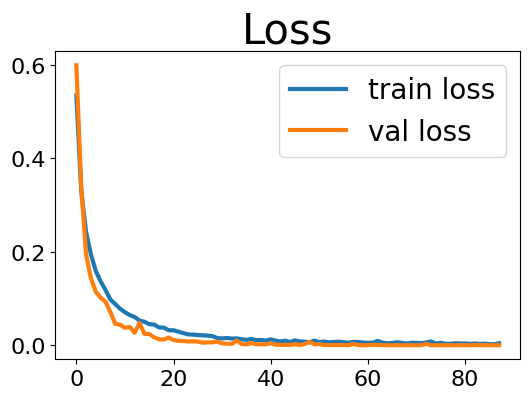

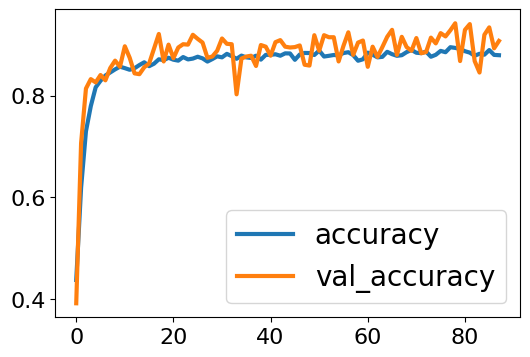

In [30]:
ch.plot_history(history, figsize=(6,4))

In [16]:
#best_model.save("model/mlc_cnn_optuna_tpesampler_v2.4.h5")

# 3. Evaluation of the optimized model and saving the results

In [16]:
best_model = load_model("model/mlc_cnn_optuna_tpesampler_v2.4.h5")
best_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_15 (Conv1D)          (None, 913, 64)           576       
                                                                 
 max_pooling1d_15 (MaxPoolin  (None, 228, 64)          0         
 g1D)                                                            
                                                                 
 conv1d_16 (Conv1D)          (None, 221, 64)           32832     
                                                                 
 max_pooling1d_16 (MaxPoolin  (None, 55, 64)           0         
 g1D)                                                            
                                                                 
 batch_normalization_10 (Bat  (None, 55, 64)           256       
 chNormalization)                                                
                                                      

In [17]:
prediction = best_model.predict(x_test)
y_pred = ch.make_pred_mlc(prediction, threshold=0.5)
acc, ham = ch.mlc_result(y_test, y_pred)



acc: 0.9506666666666667
hamming loss: 0.007666666666666666

              precision    recall  f1-score   support

           0      1.000     1.000     1.000        50
           1      0.990     0.980     0.985       100
           2      0.974     0.955     0.965       200
           3      0.995     0.990     0.992       200
           4      0.948     0.920     0.934       100
           5      0.993     0.987     0.990       150
           6      1.000     0.960     0.980       150
           7      0.992     0.992     0.992       250

   micro avg      0.987     0.974     0.981      1200
   macro avg      0.987     0.973     0.980      1200
weighted avg      0.987     0.974     0.981      1200
 samples avg      0.987     0.978     0.980      1200



In [47]:
dfzip = ch.convert_and_zip_label(y_test, y_pred)
ch.cm_multi(dfzip, fontsizestr="16px")

Pred,0,1,2,3,4,5,6,7,12,16,24,25,27,35,37,57,267,357,Total
True,,,,,,,,,,,,,,,,,,,
0,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,50
1,0,49,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,50
2,0,1,46,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,50
3,0,0,0,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,50
4,0,0,0,0,47,0,0,0,0,0,3,0,0,0,0,0,0,0,50
5,0,0,0,0,0,48,0,1,0,0,0,0,0,1,0,0,0,0,50
6,0,0,0,0,0,0,50,0,0,0,0,0,0,0,0,0,0,0,50
7,0,0,0,0,0,0,0,50,0,0,0,0,0,0,0,0,0,0,50
16,0,4,0,0,1,0,1,0,1,43,0,0,0,0,0,0,0,0,50


In [22]:
res = ch.collect_results_mlc(y_test, y_pred, algorithm="cnn_optuna_tpe", params="optuna_tpe", best_param=best_param)
res

{'algorithm': 'cnn_optuna_tpe',
 'params': 'optuna_tpe',
 'best_param': {'filters': 64,
  'kernel_size': 8,
  'maxpool': 4,
  'conv_layer': 3,
  'bn_conv': True,
  'bn_conv_position': 2,
  'dropout': 0.4,
  'dense_layer': 4,
  'bn_dense': True,
  'bn_dense_position': 3,
  'dropout_conv': True,
  'unit1': 280,
  'unit2': 40,
  'unit3': 40,
  'dropout_dense': True,
  'unit4': 40,
  'lr': 0.0001536397729138443,
  'batch_size': 16},
 'rec_0': 1.0,
 'pre_0': 1.0,
 'f1_0': 1.0,
 'rec_weighted': 0.9741666666666666,
 'pre_weighted': 0.9872679020527422,
 'f1_weighted': 0.9806273082154807,
 'acc': 0.9506666666666667}

In [23]:
#ch.save_results_json(filename="mlc_algorithm_adaption_hyperopt_results_v2.4.json", 
                     key_algorithm = "cnn_optuna_tpe", 
                     hyperopt_result = res)

existing file mlc_algorithm_adaption_hyperopt_results_v2.4.json opened and results of cnn_optuna_tpe saved.
